results in curation_OPERA_NaefAcree.xlsx

In [1]:
import pandas as pd
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Draw
IPythonConsole.molSize = (450,200)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
IPythonConsole.ipython_maxProperties = -1

In [2]:
df_combined = pd.read_csv('tmp_data/df_combined_298K_compact.csv')
df_combined = df_combined[df_combined.source != 'REACH']
df_combined

standardized_smiles  log10_VP_Pa  \
0                              CC(O)C(=O)O     1.035002   
1                 O=C(O)c1c(Cl)ccc(Cl)c1Cl    -1.134698   
2         c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34    -6.135498   
3     COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C    -4.594099   
4                     O=C(O)c1cccc(Cl)c1Cl    -1.517198   
...                                    ...          ...   
4434                                    CF     6.582000   
4435                                   C#C     6.591000   
4436                                FC(F)F     6.672000   
4437                                     C     7.790000   
4438                             FC(F)(F)F     7.910000   

                         inchikey      source  
0     JVTAAEKCZFNVCJ-UHFFFAOYSA-N       OPERA  
1     XZIDTOHMJBOSOX-UHFFFAOYSA-N       OPERA  
2     FMMWHPNWAFZXNH-UHFFFAOYSA-N       OPERA  
3     ZPUCINDJVBIVPJ-UHFFFAOYSA-N       OPERA  
4     QAOJBHRZQQDFHA-UHFFFAOYSA-N       OPERA  
...                           ...         ...  
4434  NBVXSUQYWXRMNV-UHFFFAOYSA-N  Naef_Acree  
4435  HSFWRNGVRCDJHI-UHFFFAOYSA-N  Naef_Acree  
4436  XPDWGBQVDMORPB-UHFFFAOYSA-N  Naef_Acree  
4437  VNWKTOKETHGBQD-UHFFFAOYSA-N  Naef_Acree  
4438  TXEYQDLBPFQVAA-UHFFFAOYSA-N  Naef_Acree  

[4439 rows x 4 columns]

## Issue one: wrong mols in OPERA based on CAS

959-98-8 not the same
O=S1OC[C@@H]2[C@H](CO1)[C@]1(Cl)C(Cl)=C(Cl)[C@@]2(Cl)C1(Cl)Cl
O=S1OCC2C(CO1)C1(Cl)C(Cl)=C(Cl)C2(Cl)C1(Cl)Cl|O=S1OC[C@@H]2[C@H](CO1)[C@]1(Cl)C(Cl)=C(Cl)[C@@]2(Cl)C1(Cl)Cl|O=S1OC[C@H]2[C@@H](CO1)[C@]1(Cl)C(Cl)=C(Cl)[C@]2(Cl)C1(Cl)Cl
----
763-29-1 not the same
CCCC(C)=C
CCCCC(C)=C
----
2438-04-2 not the same
CC(C)C1C=CC=CC=1C(O)=O
CC(C)OC(=O)c1ccccc1
----
21981-48-6 not the same
CCCC(C)O[N+]([O-])=O
CC(C)CCO[N+]([O-])=O
----
541-88-8 not the same
O=C(CCl)OC(=O)CCl
CC1(C)/C(=C\C=C2/CCC(C=CC3=[N+](CCCS([O-])(=O)=O)c4ccc5ccccc5c4C3(C)C)=C/2N2CCN(CC2)C(=O)OCC)/N(CCCS(O)(=O)=O)c2ccc3ccccc3c12.CCN(CC)CC
----
1538-75-6 not the same
CC(C)(C)C(=O)OC(=O)C(C)(C)C
[Pr+3].CC(C)(C)C(=O)[CH-]C(=O)C(C)(C)C.CC(C)(C)C(=O)[CH-]C(=O)C(C)(C)C.CC(C)(C)C(=O)[CH-]C(=O)C(C)(C)C
----
4101-68-2 not the same
BrCCCCCCCCCCBr
CCCCCCCCC(Br)CBr
----
19398-53-9 not the same
CC(Br)CC(C)Br
CCCC(Br)CBr
----


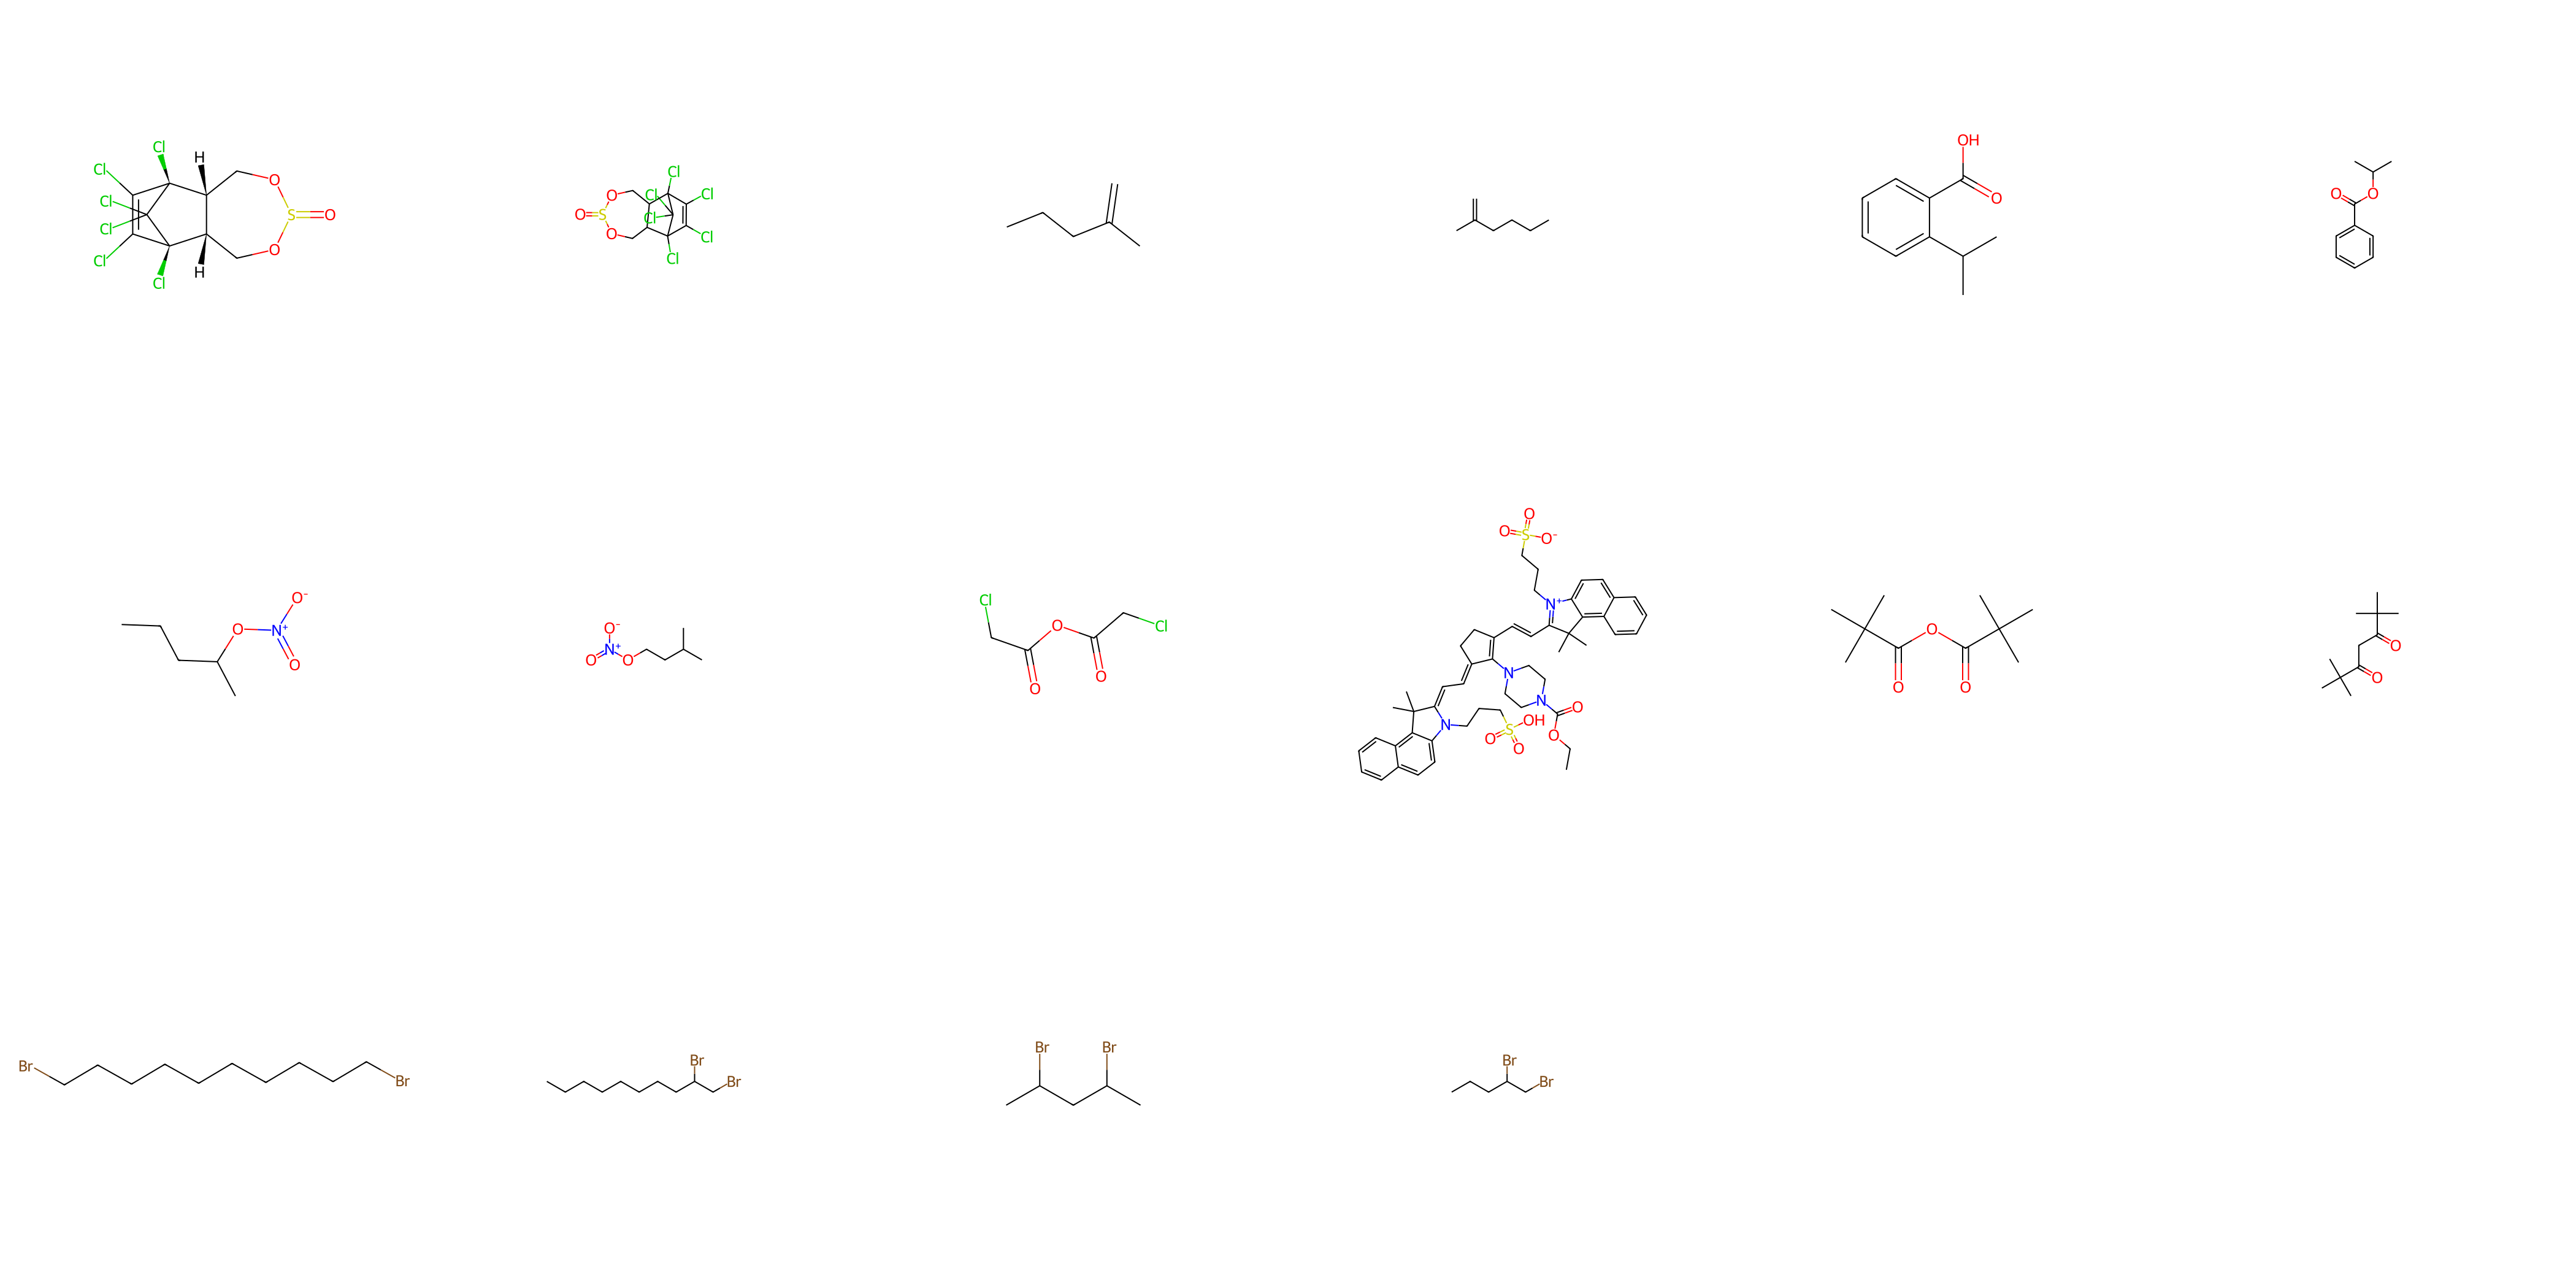

In [3]:
# Set the SDF file path
sdf_path = '/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/OPERA_Data/VP_QR.sdf'

# Read molecules from the SDF file
mols_opera = Chem.SDMolSupplier(sdf_path)

# Read the CSV file
df_vp_update = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/OPERA_Data/VP_2.9_update.csv')

# Extract properties from molecules
OPERA_cas = [mol.GetProp('CAS') for mol in mols_opera]
OPERA_source_casrn = [mol.GetProp('source_casrn') for mol in mols_opera]
Original_SMILES = [mol.GetProp('Original_SMILES') for mol in mols_opera]

# Filter non-matching CAS
df_OPREA_cas_not_same = pd.DataFrame({'CAS': OPERA_cas, 'source_casrn': OPERA_source_casrn, 'Original_SMILES': Original_SMILES})
df_OPREA_cas_not_same = df_OPREA_cas_not_same[df_OPREA_cas_not_same['source_casrn'] != df_OPREA_cas_not_same['CAS'] + '|?']

# Drop rows with CAS containing '|'
indeces_to_drop = [i for i, (cas, source_casrn) in enumerate(zip(df_OPREA_cas_not_same['CAS'], df_OPREA_cas_not_same['source_casrn'])) if '|' in cas and len(set(cas.split('|')).intersection(set(source_casrn.split('|')))) > 0]
df_OPREA_cas_not_same = df_OPREA_cas_not_same[~df_OPREA_cas_not_same.index.isin(indeces_to_drop)]

# Find non-matching SMILES between CSV and SDF
non_matching_smiles_df_update = []
non_matching_smiles_sdf = []
cas_from_sdf_to_edit = []
smiles_to_edit_from, smiles_to_edit_to = [], []

for cas, smi in zip(df_OPREA_cas_not_same['source_casrn'], df_OPREA_cas_not_same['Original_SMILES']):
    cas_split = cas.split('|')
    for c in cas_split:
        try:
            smiles_in_df = df_vp_update[df_vp_update['CASRN'] == c]['Original_SMILES'].iloc[0]
        except IndexError:
            continue
        if smiles_in_df != smi:
            print(f'{c} not the same')
            cas_from_sdf_to_edit.append(c)
            print(smiles_in_df)
            print(smi)
            print('----')
            non_matching_smiles_df_update.append(smiles_in_df)
            non_matching_smiles_sdf.append(smi)
            smiles_to_edit_from.append(smi)
            smiles_to_edit_to.append(smiles_in_df)

# Create standardized molecules
mols_df = [Chem.MolFromSmiles(smi) for smi in non_matching_smiles_df_update]
mols_sdf = [mol for mol in mols_opera if mol.GetProp('Original_SMILES') in non_matching_smiles_sdf]
mols_combined = []
for mol_df, mol_sdf in zip(mols_df, mols_sdf):
    if mol_df is None or mol_sdf is None:
        continue
    mols_combined.append(mol_df)
    mols_combined.append(mol_sdf)
# Display the molecules in a grid image
img = Draw.MolsToGridImage(mols_combined, molsPerRow=6, subImgSize=(700, 700))
img

In [4]:
mols_combined_standardized = [rdMolStandardize.ChargeParent(mol) for mol in mols_combined]
sdf_mols_standardized = mols_combined_standardized[1::2]
df_mols_standardized = mols_combined_standardized[::2]
wrong_mols_smiles = [Chem.MolToSmiles(smi) for smi in sdf_mols_standardized]
right_mols_smiles = [Chem.MolToSmiles(smi) for smi in df_mols_standardized]
df_combined[df_combined['standardized_smiles'].isin(wrong_mols_smiles)]

[14:49:43] Initializing MetalDisconnector
[14:49:43] Running MetalDisconnector
[14:49:43] Initializing Normalizer
[14:49:43] Running Normalizer
[14:49:43] Running LargestFragmentChooser
[14:49:43] Fragment: O=S1OC[C@@H]2[C@H](CO1)[C@]1(Cl)C(Cl)=C(Cl)[C@@]2(Cl)C1(Cl)Cl
[14:49:43] New largest fragment: O=S1OC[C@@H]2[C@H](CO1)[C@]1(Cl)C(Cl)=C(Cl)[C@@]2(Cl)C1(Cl)Cl (25)
[14:49:43] Running Uncharger
[14:49:43] Initializing MetalDisconnector
[14:49:43] Running MetalDisconnector
[14:49:43] Initializing Normalizer
[14:49:43] Running Normalizer
[14:49:43] Initializing MetalDisconnector
[14:49:43] Running MetalDisconnector
[14:49:43] Initializing Normalizer
[14:49:43] Running Normalizer
[14:49:43] Running LargestFragmentChooser
[14:49:43] Fragment: O=S1OCC2C(CO1)C1(Cl)C(Cl)=C(Cl)C2(Cl)C1(Cl)Cl
[14:49:43] New largest fragment: O=S1OCC2C(CO1)C1(Cl)C(Cl)=C(Cl)C2(Cl)C1(Cl)Cl (25)
[14:49:43] Running Uncharger
[14:49:43] Initializing MetalDisconnector
[14:49:43] Running MetalDisconnector
[14:49:43] In

standardized_smiles  log10_VP_Pa  \
810       O=S1OCC2C(CO1)C1(Cl)C(Cl)=C(Cl)C2(Cl)C1(Cl)Cl    -4.637097   
1562                                         C=C(C)CCCC     4.162301   
1806                                CC(C)OC(=O)c1ccccc1    -1.334398   
2022                               CC(C)CCO[N+](=O)[O-]     2.835002   
2318  CCOC(=O)N1CCN(C2=C(/C=C/C3=[N+](CCCS(=O)(=O)[O...     0.695302   
2332                        CC(C)(C)C(=O)CC(=O)C(C)(C)C     1.768402   
2337                                   CCCCCCCCC(Br)CBr    -0.303999   
2350                                        CCCC(Br)CBr     2.278403   
4052                                         C=C(C)CCCC     3.909000   

                         inchikey      source  
810   RDYMFSUJUZBWLH-UHFFFAOYSA-N       OPERA  
1562  IRUDSQHLKGNCGF-UHFFFAOYSA-N       OPERA  
1806  FEXQDZTYJVXMOS-UHFFFAOYSA-N       OPERA  
2022  NTHGIYFSMNNHSC-UHFFFAOYSA-N       OPERA  
2318  ZVTSEGXUAUCYQH-UHFFFAOYSA-N       OPERA  
2332  YRAJNWYBUCUFBD-UHFFFAOYSA-N       OPERA  
2337  XBRBOTTWTQOCJH-UHFFFAOYSA-N       OPERA  
2350  CITMYAPULDSOHG-UHFFFAOYSA-N       OPERA  
4052  IRUDSQHLKGNCGF-UHFFFAOYSA-N  Naef_Acree

In [5]:
df_combined[df_combined['standardized_smiles'].isin(right_mols_smiles)]

standardized_smiles  log10_VP_Pa                     inchikey      source
4206           C=C(C)CCC        4.406  WWUVJRULCWHUSA-UHFFFAOYSA-N  Naef_Acree

In [6]:
df_combined.loc[(df_combined['source'] == 'OPERA') & (df_combined['standardized_smiles'].isin(wrong_mols_smiles)), 'standardized_smiles'] = right_mols_smiles
df_combined[df_combined['standardized_smiles'].isin(right_mols_smiles)]

standardized_smiles  log10_VP_Pa  \
810   O=S1OC[C@@H]2[C@H](CO1)[C@]1(Cl)C(Cl)=C(Cl)[C@...    -4.637097   
1562                                          C=C(C)CCC     4.162301   
1806                                CC(C)c1ccccc1C(=O)O    -1.334398   
2022                               CCCC(C)O[N+](=O)[O-]     2.835002   
2318                                  O=C(CCl)OC(=O)CCl     0.695302   
2332                        CC(C)(C)C(=O)OC(=O)C(C)(C)C     1.768402   
2337                                     BrCCCCCCCCCCBr    -0.303999   
2350                                      CC(Br)CC(C)Br     2.278403   
4206                                          C=C(C)CCC     4.406000   

                         inchikey      source  
810   RDYMFSUJUZBWLH-UHFFFAOYSA-N       OPERA  
1562  IRUDSQHLKGNCGF-UHFFFAOYSA-N       OPERA  
1806  FEXQDZTYJVXMOS-UHFFFAOYSA-N       OPERA  
2022  NTHGIYFSMNNHSC-UHFFFAOYSA-N       OPERA  
2318  ZVTSEGXUAUCYQH-UHFFFAOYSA-N       OPERA  
2332  YRAJNWYBUCUFBD-UHFFFAOYSA-N       OPERA  
2337  XBRBOTTWTQOCJH-UHFFFAOYSA-N       OPERA  
2350  CITMYAPULDSOHG-UHFFFAOYSA-N       OPERA  
4206  WWUVJRULCWHUSA-UHFFFAOYSA-N  Naef_Acree

In [7]:
df_combined[df_combined['inchikey'] == 'WQZGKKKJIJFFOK-UHFFFAOYSA-N']


standardized_smiles  log10_VP_Pa                     inchikey source
1126  OCC1OC(O)C(O)C(O)C1O   -10.970898  WQZGKKKJIJFFOK-UHFFFAOYSA-N  OPERA

In [8]:
mols_oja_suuberg = [mol for mol in mols_opera if mol.GetProp('VP Reference') == 'OJA,V & SUUBERG (1999)']
standardized_smiles_oja_suuberg = [Chem.MolToSmiles(rdMolStandardize.ChargeParent(mol)) for mol in mols_oja_suuberg]
df_combined[df_combined['standardized_smiles'].isin(standardized_smiles_oja_suuberg)]

[14:49:44] Initializing MetalDisconnector
[14:49:44] Running MetalDisconnector
[14:49:44] Initializing Normalizer
[14:49:44] Running Normalizer
[14:49:44] Running LargestFragmentChooser
[14:49:44] Fragment: O=CC(O)C(O)C(O)CO
[14:49:44] New largest fragment: O=CC(O)C(O)C(O)CO (20)
[14:49:44] Running Uncharger
[14:49:44] Initializing MetalDisconnector
[14:49:44] Running MetalDisconnector
[14:49:44] Initializing Normalizer
[14:49:44] Running Normalizer
[14:49:44] Initializing MetalDisconnector
[14:49:44] Running MetalDisconnector
[14:49:44] Initializing Normalizer
[14:49:44] Running Normalizer
[14:49:44] Running LargestFragmentChooser
[14:49:44] Fragment: OCC1OC(O)C(O)C(O)C1O
[14:49:44] New largest fragment: OCC1OC(O)C(O)C(O)C1O (24)
[14:49:44] Running Uncharger
[14:49:44] Initializing MetalDisconnector
[14:49:44] Running MetalDisconnector
[14:49:44] Initializing Normalizer
[14:49:44] Running Normalizer
[14:49:44] Initializing MetalDisconnector
[14:49:44] Running MetalDisconnector
[14:49:

standardized_smiles  log10_VP_Pa                     inchikey source
25       O=CC(O)C(O)C(O)CO    -7.580599  PYMYPHUHKUWMLA-UHFFFAOYSA-N  OPERA
1126  OCC1OC(O)C(O)C(O)C1O   -10.970898  WQZGKKKJIJFFOK-UHFFFAOYSA-N  OPERA
2317   OC1C2COC(O2)C(O)C1O    -4.999998  TWNIBLMWSKIRAT-UHFFFAOYSA-N  OPERA

In [9]:
df_combined = df_combined[~df_combined['standardized_smiles'].isin(standardized_smiles_oja_suuberg)]


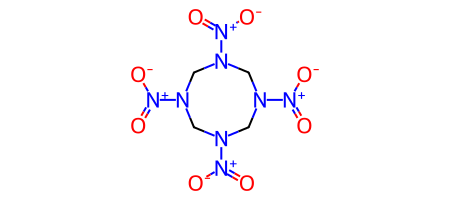

In [10]:
HMX_mol = [mol for mol in mols_opera if mol.GetProp('preferred_name') == 'Cyclotetramethylenetetranitramine'][0]
HMX_mol

In [11]:
#recent paper: Vapor Pressures of RDX and HMX Explosives Measured at and Near Room Temperature: 1,3,5-Trinitro-1,3,5-triazinane and 1,3,5,7-Tetranitro-1,3,5,7-tetrazocane
#set the vapor pressure of HMX to 1.5e-15 atm
vp_atm = 1.5e-15
vp_pascal = vp_atm * 101325
import numpy as np
vp_log10_pa = np.log10(vp_pascal)
print(vp_log10_pa)
#change the vapor pressure of HMX in the dataframe
df_combined[df_combined['standardized_smiles'] == Chem.MolToSmiles(HMX_mol)]

-9.818192128530589


standardized_smiles  log10_VP_Pa  \
1834  O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...   -11.356599   

                         inchikey source  
1834  UZGLIIJVICEWHF-UHFFFAOYSA-N  OPERA

In [12]:
df_combined.loc[df_combined['standardized_smiles'] == Chem.MolToSmiles(HMX_mol), 'log10_VP_Pa'] = vp_log10_pa
df_combined[df_combined['standardized_smiles'] == Chem.MolToSmiles(HMX_mol)]

standardized_smiles  log10_VP_Pa  \
1834  O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...    -9.818192   

                         inchikey source  
1834  UZGLIIJVICEWHF-UHFFFAOYSA-N  OPERA

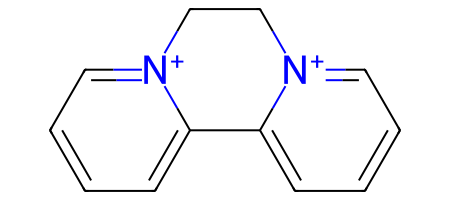

In [13]:
diquat_mol = [mol for mol in mols_opera if mol.GetProp('preferred_name') == 'Diquat'][0]
diquat_mol

In [14]:
##crossval with this df
df_combined

standardized_smiles  log10_VP_Pa  \
0                              CC(O)C(=O)O     1.035002   
1                 O=C(O)c1c(Cl)ccc(Cl)c1Cl    -1.134698   
2         c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34    -6.135498   
3     COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C    -4.594099   
4                     O=C(O)c1cccc(Cl)c1Cl    -1.517198   
...                                    ...          ...   
4434                                    CF     6.582000   
4435                                   C#C     6.591000   
4436                                FC(F)F     6.672000   
4437                                     C     7.790000   
4438                             FC(F)(F)F     7.910000   

                         inchikey      source  
0     JVTAAEKCZFNVCJ-UHFFFAOYSA-N       OPERA  
1     XZIDTOHMJBOSOX-UHFFFAOYSA-N       OPERA  
2     FMMWHPNWAFZXNH-UHFFFAOYSA-N       OPERA  
3     ZPUCINDJVBIVPJ-UHFFFAOYSA-N       OPERA  
4     QAOJBHRZQQDFHA-UHFFFAOYSA-N       OPERA  
...                           ...         ...  
4434  NBVXSUQYWXRMNV-UHFFFAOYSA-N  Naef_Acree  
4435  HSFWRNGVRCDJHI-UHFFFAOYSA-N  Naef_Acree  
4436  XPDWGBQVDMORPB-UHFFFAOYSA-N  Naef_Acree  
4437  VNWKTOKETHGBQD-UHFFFAOYSA-N  Naef_Acree  
4438  TXEYQDLBPFQVAA-UHFFFAOYSA-N  Naef_Acree  

[4436 rows x 4 columns]

In [15]:
from sklearn.model_selection import RepeatedKFold
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pickle
from sklearn.preprocessing import StandardScaler
def train_grouped_kfold(df,params,descriptors,name='test',split_on = 'molregno',y='vp_log10pa',n_splits=5,n_repeats=3,random_state=2652124,normalize_x=False):
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    X = df[split_on].to_numpy()
    output = ([],[],[],[],[],[],[],[],[],[],[])
    for i, (train_index, test_index) in enumerate(rkf.split(X)):
        train_all = df[df[split_on].isin(X[train_index])]
        test_all = df[df[split_on].isin(X[test_index])]

        train_X = train_all[descriptors]
        train_y = train_all[y]
        test_X = test_all[descriptors]
        test_y = test_all[y]
        molregnos_test = test_all[split_on]

        if normalize_x:
            scaler = StandardScaler()
            train_X = scaler.fit_transform(train_X)
            test_X = scaler.transform(test_X)

        dtrain = xgb.DMatrix(train_X, label=train_y)
        dtest = xgb.DMatrix(test_X, label=test_y)

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            verbose_eval=False
        )

        preds = model.predict(dtest)
        output[0].append(test_y.to_list())
        output[1].append(list(preds))
        output[2].append(molregnos_test.to_list())


        #print the RMSEs
        rmse = mean_squared_error(test_y, preds, squared=False)
        print(f"Fold {i + 1}: RMSE = {rmse}")

    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(output, f)

    return output

import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import scipy.stats as stats

def getStatValues_v2(x,y,treshold=1):
    RMSE = mean_squared_error(np.array(x), np.array(y), squared=False)
    MAE = mean_absolute_error(np.array(x), np.array(y))
    EBO = np.mean(np.abs(np.array(x) - np.array(y)) < treshold)
    KT = stats.kendalltau(x, y)[0]
    median_AE = median_absolute_error(np.array(x), np.array(y))

    return RMSE, MAE, EBO, KT, median_AE

def density_plot_single_custom_local(reals, predictions, molregnos, print_stats=True, bounds=None, title=None, print_spearman=False, name=None):
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    rmses, maes, ebos, kts,median_aes = [], [], [], [],[]
    
    for r, p in zip(reals, predictions):
        RMSE, MAE, EBO, KT,median_AE = getStatValues_v2(r, p)
        rmses.append(RMSE)
        maes.append(MAE)
        ebos.append(EBO)
        kts.append(KT)
        median_aes.append(median_AE)
    
    rmse_90_low, rmse_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(rmses), scale=stats.sem(rmses))
    rmse_mean = np.mean(rmses)
    mae_90_low, mae_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(maes), scale=stats.sem(maes))
    mae_mean = np.mean(maes)
    ebo_90_low, ebo_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(ebos), scale=stats.sem(ebos))
    ebo_mean = np.mean(ebos)
    kt_90_low, kt_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(kts), scale=stats.sem(kts))
    kt_mean = np.mean(kts)
    median_AE_90_low, median_AE_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(median_aes), scale=stats.sem(median_aes))
    median_AE_mean = np.mean(median_aes)

    
    # molregno = molregnos[0]
    
    mrn = [item for sublist in molregnos for item in sublist]
    real = [item for sublist in reals for item in sublist]
    prediction = [item for sublist in predictions for item in sublist]
    
    df = pd.DataFrame({'molregno': mrn, 'real': real, 'prediction': prediction})
    df = df.groupby('molregno').mean()
    real = df['real'].tolist()
    prediction = df['prediction'].tolist()
    
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')
    
    dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
    z = dens_u.pdf([real, prediction])
    
    sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)
    
    ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
    ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
    ax.grid(True, which="both")
    
    if bounds is None:
        lower = min(prediction + real) - 2
        upper = max(prediction + real) + 2
    else:
        lower = bounds[0]
        upper = bounds[1]
    
    ax.axis([lower, upper, lower, upper])
    
    text_box = ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMedian AE: {median_AE_mean:.2f} ({median_AE_90_low:.2f}-{median_AE_90_high:.2f})\nMean AE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})', 
                       transform=ax.transAxes, fontsize=12, verticalalignment='top',
                       bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    if title is not None:
        ax.set_title(title, fontsize=14)
    
    ax.set_aspect('equal', 'box')
    
    if name:
        plt.savefig(name+'.png', dpi=600)
    
    plt.show()

In [16]:
from rdkit.Chem import Descriptors
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    #add inchikey
    res['inchikey'] = Chem.MolToInchiKey(mol)
    return res

mols = [Chem.MolFromSmiles(smi) for smi in df_combined['standardized_smiles']]
descriptors = [getMolDescriptors(m) for m in mols]
descriptor_df = pd.DataFrame(descriptors)
df_combined_descritptors = df_combined.merge(descriptor_df, on='inchikey')
df_combined_descritptors = df_combined_descritptors.drop_duplicates()
df_combined_descritptors

[14:50:01] unrecognized chirality tag (8) on atom 6 is ignored.
[14:50:01] unrecognized chirality tag (8) on atom 17 is ignored.
[14:50:01] unrecognized chirality tag (8) on atom 4 is ignored.
[14:50:01] unrecognized chirality tag (8) on atom 11 is ignored.
[14:50:02] unrecognized chirality tag (8) on atom 1 is ignored.
[14:50:02] unrecognized chirality tag (8) on atom 7 is ignored.
[14:50:02] unrecognized chirality tag (8) on atom 13 is ignored.
[14:50:02] unrecognized chirality tag (8) on atom 3 is ignored.
[14:50:02] unrecognized chirality tag (8) on atom 11 is ignored.
[14:50:02] unrecognized chirality tag (8) on atom 9 is ignored.
[14:50:02] unrecognized chirality tag (8) on atom 6 is ignored.
[14:50:03] unrecognized chirality tag (8) on atom 5 is ignored.
[14:50:03] unrecognized chirality tag (8) on atom 6 is ignored.


standardized_smiles  log10_VP_Pa  \
0                              CC(O)C(=O)O     1.035002   
1                 O=C(O)c1c(Cl)ccc(Cl)c1Cl    -1.134698   
2         c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34    -6.135498   
4         c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34    -6.135000   
6     COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C    -4.594099   
...                                    ...          ...   
6427                               FC(F)Br     5.639000   
6428                        F/C=C/C(F)(F)F     5.698000   
6429                                   C=O     5.710000   
6430        FC(F)(F)OO[S@OH5](F)(F)(F)(F)F     5.821000   
6431                        C=C(F)C(F)(F)F     5.834000   

                         inchikey      source  MaxAbsEStateIndex  \
0     JVTAAEKCZFNVCJ-UHFFFAOYSA-N       OPERA           9.449074   
1     XZIDTOHMJBOSOX-UHFFFAOYSA-N       OPERA          10.567284   
2     FMMWHPNWAFZXNH-UHFFFAOYSA-N       OPERA           2.309074   
4     FMMWHPNWAFZXNH-UHFFFAOYSA-N  Naef_Acree           2.309074   
6     ZPUCINDJVBIVPJ-UHFFFAOYSA-N       OPERA          12.296709   
...                           ...         ...                ...   
6427  GRCDJFHYVYUNHM-UHFFFAOYSA-N  Naef_Acree          10.250000   
6428  CDOOAUSHHFGWSA-OWOJBTEDSA-N  Naef_Acree          10.729167   
6429  WSFSSNUMVMOOMR-UHFFFAOYSA-N  Naef_Acree           8.000000   
6430  QYSKJQVQYGRSJM-UHFFFAOYSA-N  Naef_Acree          10.898472   
6431  FXRLMCRCYDHQFW-UHFFFAOYSA-N  Naef_Acree          10.888889   

      MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed    MolWt  \
0           9.449074           1.185185       -1.231481  0.453936   90.078   
1          10.567284           0.030864       -1.187500  0.744344  225.458   
2           2.309074           1.317945        1.317945  0.243454  252.316   
4           2.309074           1.317945        1.317945  0.243454  252.316   
6          12.296709           0.097012       -0.408467  0.797936  303.358   
...              ...                ...             ...       ...      ...   
6427       10.250000           1.937500       -2.354167  0.437677  130.919   
6428       10.729167           0.479167       -4.505208  0.422449  114.041   
6429        8.000000           2.000000        2.000000  0.360624   30.026   
6430       10.898472           1.128472      -10.594807  0.407488  228.060   
6431       10.888889           2.034722       -4.861111  0.422449  114.041   

      ...  fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  \
0     ...           0             0           0                  0   
1     ...           0             0           0                  0   
2     ...           0             0           0                  0   
4     ...           0             0           0                  0   
6     ...           0             0           0                  0   
...   ...         ...           ...         ...                ...   
6427  ...           0             0           0                  0   
6428  ...           0             0           0                  0   
6429  ...           0             0           0                  0   
6430  ...           0             0           0                  0   
6431  ...           0             0           0                  0   

      fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  \
0                0            0            0             0                 0   
1                0            0            0             0                 0   
2                0            0            0             0                 0   
4                0            0            0             0                 0   
6                0            0            0             0                 0   
...            ...          ...          ...           ...               ...   
6427             0            0            0             0                 0   
6428             0            0            0             0                 0   

In [17]:
params = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
outputs_combined = train_grouped_kfold(df_combined_descritptors,params,RDKit_feature_names,name='outputs_combined_no_duplicates',split_on = 'inchikey',y='log10_VP_Pa',n_splits=5,n_repeats=3,random_state=2652124,normalize_x=False)

Fold 1: RMSE = 0.5707799188502383
Fold 2: RMSE = 0.6170238682288333
Fold 3: RMSE = 0.5968867812670656
Fold 4: RMSE = 0.6226446599791657
Fold 5: RMSE = 0.626257154035002
Fold 6: RMSE = 0.629870886456428
Fold 7: RMSE = 0.5905376946519311
Fold 8: RMSE = 0.630455371069286
Fold 9: RMSE = 0.5538353124773753
Fold 10: RMSE = 0.6373272069505346
Fold 11: RMSE = 0.5854571160020939
Fold 12: RMSE = 0.5947648636102874
Fold 13: RMSE = 0.6241154908195463
Fold 14: RMSE = 0.5697543368529826
Fold 15: RMSE = 0.594220467057343


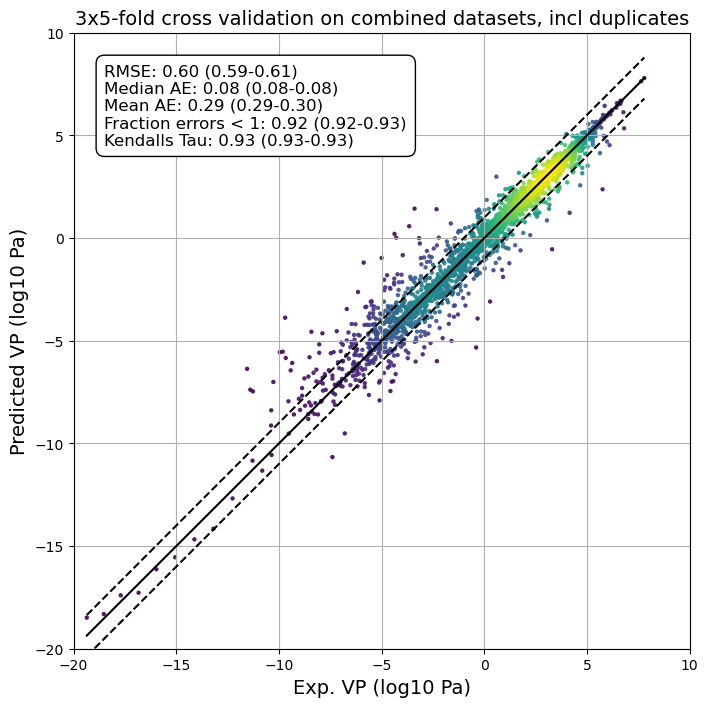

In [18]:
density_plot_single_custom_local(reals = outputs_combined[0], predictions = outputs_combined[1], bounds=[-20,10], molregnos=outputs_combined[2], title='3x5-fold cross validation on combined datasets, incl duplicates')

6.680627845194822


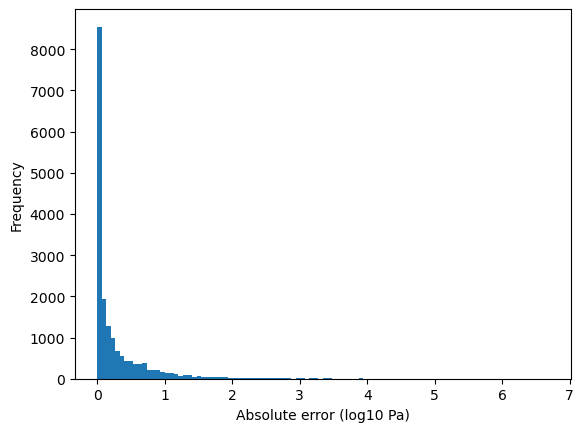

In [79]:
abs_errors_list = []
for reals,preds in zip(outputs_combined[0],outputs_combined[1]):
    abs_errors = np.abs(np.array(reals) - np.array(preds))
    abs_errors_list.extend(abs_errors)
print(max(abs_errors_list))
plt.hist(abs_errors_list, bins=100)
plt.xlabel('Absolute error (log10 Pa)')
plt.ylabel('Frequency')
plt.show()



In [80]:
#make df of reals, preds, inchikeys, molregnos
reals = outputs_combined[0]
preds = outputs_combined[1]
inchikeys = outputs_combined[2]
reals_flat = [item for sublist in reals for item in sublist]
preds_flat = [item for sublist in preds for item in sublist]
inchikeys_flat = [item for sublist in inchikeys for item in sublist]
df_CV_new_set = pd.DataFrame({'reals': reals_flat, 'preds': preds_flat, 'inchikey': inchikeys_flat})
df_CV_new_set = df_CV_new_set.groupby('inchikey').mean()
df_CV_new_set['abs_error'] = np.abs(df_CV_new_set['reals']-df_CV_new_set['preds'])
df_CV_new_set.sort_values(by=['abs_error'],ascending=False,inplace=True)
#print number of datapoints with error > 1, 2, 3
print(len(df_CV_new_set[df_CV_new_set['abs_error']>1]), ' datapoints with error > 1')
print(len(df_CV_new_set[df_CV_new_set['abs_error']>2]), ' datapoints with error > 2')
print(len(df_CV_new_set[df_CV_new_set['abs_error']>3]), ' datapoints with error > 3')
df_CV_new_set

335  datapoints with error > 1
90  datapoints with error > 2
30  datapoints with error > 3


reals     preds  abs_error
inchikey                                                   
KCXVZYZYPLLWCC-UHFFFAOYSA-N  -9.698998 -3.881146   5.817852
XMQFTWRPUQYINF-UHFFFAOYSA-N -11.552897 -6.368315   5.184582
YLTPZAWSNFUXES-ROUUACIJSA-N  -0.398000 -5.329370   4.931370
QAYICIQNSGETAS-UHFFFAOYSA-N  -3.398000  1.433933   4.831933
SYJFEGQWDCRVNX-UHFFFAOYSA-N  -5.875098 -1.196738   4.678360
...                                ...       ...        ...
FGLBSLMDCBOPQK-UHFFFAOYSA-N   3.355749  3.355756   0.000007
KDKYADYSIPSCCQ-UHFFFAOYSA-N   5.275151  5.275146   0.000005
VXNZUUAINFGPBY-UHFFFAOYSA-N   5.353551  5.353548   0.000003
LJSQFQKUNVCTIA-UHFFFAOYSA-N   3.897251  3.897254   0.000003
JAYCNKDKIKZTAF-UHFFFAOYSA-N  -0.460899 -0.460902   0.000003

[3427 rows x 3 columns]

In [81]:
from rdkit.Chem import Draw
df_CV_new_set_error_over_2 = df_CV_new_set[df_CV_new_set['abs_error'] > 2]
df_CV_new_set_error_over_2.sort_values(by=['abs_error'],ascending=False,inplace=True)
df_CV_new_set_error_over_2
inchis_error_sorted = df_CV_new_set_error_over_2.index.to_list()
preds = df_CV_new_set_error_over_2['preds'].to_list()
sources, ground_truths, smiles = [], [], []
pred_list,inchikey_list = [],[]
for inchikey,pred in zip(inchis_error_sorted,preds):
    df_subset = df_combined[df_combined['inchikey']==inchikey]
    sources.extend(df_subset['source'].to_list())
    ground_truths.extend(df_subset['log10_VP_Pa'].to_list())
    smiles.extend(df_subset['standardized_smiles'].to_list())
    inchikey_list.extend(df_subset['inchikey'].to_list())
    pred_list.extend([pred]*len(df_subset))
df_to_check = pd.DataFrame({'source':sources,'ground_truth':ground_truths,'smiles':smiles,'preds':pred_list,'inchikey':inchikey_list})
df_to_check
#draw first 10 with ground_truth, pred, source
df_to_check_subset = df_to_check.iloc[:10]
mols = [Chem.MolFromSmiles(smi) for smi in df_to_check_subset['smiles']]
ground_truths = df_to_check_subset['ground_truth'].to_list()
preds = df_to_check_subset['preds'].to_list()
sources = df_to_check_subset['source'].to_list()
# img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(700, 700), legends=[f'ground_truth: {round(ground_truth,2)}\npred: {round(pred,2)}\nsource: {source}' for ground_truth,pred,source in zip(ground_truths,preds,sources)])
# img


/tmp/ipykernel_91139/1529229860.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CV_new_set_error_over_2.sort_values(by=['abs_error'],ascending=False,inplace=True)


In [82]:
opera_error_mols_with_info = []
for op_mol in mols_opera:
     op_mol = rdMolStandardize.ChargeParent(op_mol)
     op_mol_inchikey = Chem.MolToInchiKey(op_mol)
     for m in mols:
          m_inchikey = Chem.MolToInchiKey(m)
          if m_inchikey == op_mol_inchikey:
               opera_error_mols_with_info.append(op_mol)
               break

[15:34:20] Initializing MetalDisconnector
[15:34:20] Running MetalDisconnector
[15:34:20] Initializing Normalizer
[15:34:20] Running Normalizer
[15:34:20] Running LargestFragmentChooser
[15:34:20] Fragment: CC(O)C(=O)O
[15:34:20] New largest fragment: CC(O)C(=O)O (12)
[15:34:20] Running Uncharger
[15:34:20] Initializing MetalDisconnector
[15:34:20] Running MetalDisconnector
[15:34:20] Initializing Normalizer
[15:34:20] Running Normalizer
[15:34:20] Initializing MetalDisconnector
[15:34:20] Running MetalDisconnector
[15:34:20] Initializing Normalizer
[15:34:20] Running Normalizer
[15:34:20] Running LargestFragmentChooser
[15:34:20] Fragment: Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1
[15:34:20] New largest fragment: Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1 (28)
[15:34:20] Running Uncharger
[15:34:20] Initializing MetalDisconnector
[15:34:20] Running MetalDisconnector
[15:34:20] Initializing Normalizer
[15:34:20] Running Normalizer
[15:34:20] Initializing MetalDisconnector
[15:34:20] Running M

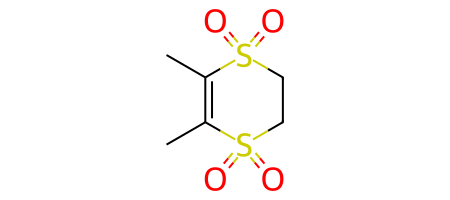

In [23]:
#confflicting data from EPA and ARS pesticide databse, remove!
np.log10(0.051*1000),np.log10((3.81*10**-7)*133.322)
opera_error_mols_with_info[6]

In [83]:
df_to_check_subset = df_to_check.iloc[10:20]
mols = [Chem.MolFromSmiles(smi) for smi in df_to_check_subset['smiles']]
opera_error_mols_with_info = []
for op_mol in mols_opera:
     op_mol = rdMolStandardize.ChargeParent(op_mol)
     op_mol_inchikey = Chem.MolToInchiKey(op_mol)
     for m in mols:
          m_inchikey = Chem.MolToInchiKey(m)
          if m_inchikey == op_mol_inchikey:
               opera_error_mols_with_info.append(op_mol)
               break

[15:34:30] Initializing MetalDisconnector
[15:34:30] Running MetalDisconnector
[15:34:30] Initializing Normalizer
[15:34:30] Running Normalizer
[15:34:30] Running LargestFragmentChooser
[15:34:30] Fragment: CC(O)C(=O)O
[15:34:30] New largest fragment: CC(O)C(=O)O (12)
[15:34:30] Running Uncharger
[15:34:30] Initializing MetalDisconnector
[15:34:30] Running MetalDisconnector
[15:34:30] Initializing Normalizer
[15:34:30] Running Normalizer
[15:34:30] Initializing MetalDisconnector
[15:34:30] Running MetalDisconnector
[15:34:30] Initializing Normalizer
[15:34:30] Running Normalizer
[15:34:30] Running LargestFragmentChooser
[15:34:30] Fragment: Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1
[15:34:30] New largest fragment: Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1 (28)
[15:34:30] Running Uncharger
[15:34:30] Initializing MetalDisconnector
[15:34:30] Running MetalDisconnector
[15:34:30] Initializing Normalizer
[15:34:30] Running Normalizer
[15:34:30] Initializing MetalDisconnector
[15:34:30] Running M

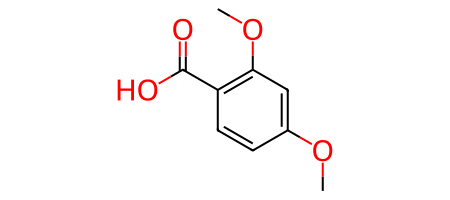

In [25]:
opera_error_mols_with_info[1]

In [26]:
df_combined

standardized_smiles  log10_VP_Pa  \
0                              CC(O)C(=O)O     1.035002   
1                 O=C(O)c1c(Cl)ccc(Cl)c1Cl    -1.134698   
2         c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34    -6.135498   
3     COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C    -4.594099   
4                     O=C(O)c1cccc(Cl)c1Cl    -1.517198   
...                                    ...          ...   
4434                                    CF     6.582000   
4435                                   C#C     6.591000   
4436                                FC(F)F     6.672000   
4437                                     C     7.790000   
4438                             FC(F)(F)F     7.910000   

                         inchikey      source  
0     JVTAAEKCZFNVCJ-UHFFFAOYSA-N       OPERA  
1     XZIDTOHMJBOSOX-UHFFFAOYSA-N       OPERA  
2     FMMWHPNWAFZXNH-UHFFFAOYSA-N       OPERA  
3     ZPUCINDJVBIVPJ-UHFFFAOYSA-N       OPERA  
4     QAOJBHRZQQDFHA-UHFFFAOYSA-N       OPERA  
...                           ...         ...  
4434  NBVXSUQYWXRMNV-UHFFFAOYSA-N  Naef_Acree  
4435  HSFWRNGVRCDJHI-UHFFFAOYSA-N  Naef_Acree  
4436  XPDWGBQVDMORPB-UHFFFAOYSA-N  Naef_Acree  
4437  VNWKTOKETHGBQD-UHFFFAOYSA-N  Naef_Acree  
4438  TXEYQDLBPFQVAA-UHFFFAOYSA-N  Naef_Acree  

[4436 rows x 4 columns]

## Overlap values Naef & Acree and OPERA

In [84]:
df1 = df_combined[df_combined['source']=='OPERA']
df2 = df_combined[df_combined['source']=='Naef_Acree']
#get overlapping inchikeys
inchikeys_source1 = df1['inchikey'].unique()
inchikeys_source2 = df2['inchikey'].unique()
inchikeys_overlap = list(set(inchikeys_source1).intersection(inchikeys_source2))
#get duplicates
df1_duplicates = df1[df1['inchikey'].isin(inchikeys_overlap)]
df2_duplicates = df2[df2['inchikey'].isin(inchikeys_overlap)]
#drop duplicates
df1_duplicates = df1_duplicates.drop_duplicates(subset=['inchikey'])
df2_duplicates = df2_duplicates.drop_duplicates(subset=['inchikey'])
#sort by inchikey
df_subset_duplicates_source1 = df1_duplicates.sort_values(by=['inchikey'])
df_subset_duplicates_source2 = df2_duplicates.sort_values(by=['inchikey'])
vals_1 = df_subset_duplicates_source1['log10_VP_Pa'].values
vals_2 = df_subset_duplicates_source2['log10_VP_Pa'].values
inchikeys_overlap = df_subset_duplicates_source1['inchikey'].values
diff = vals_1-vals_2
diff_abs = np.abs(diff)
number_larger_2 = len(diff_abs[diff_abs>2])
print(number_larger_2, ' datapoints with error > 2')
#make df of vals_1, vals_2, inchikeys
df_to_check = pd.DataFrame({'OPERA':vals_1,'Naef_Acree':vals_2,'inchikey':inchikeys_overlap})
df_to_check['abs_diff'] = np.abs(df_to_check['OPERA']-df_to_check['Naef_Acree'])
df_to_check.sort_values(by=['abs_diff'],ascending=False,inplace=True)
df_to_check.head(19)

19  datapoints with error > 2


OPERA  Naef_Acree                     inchikey  abs_diff
810 -8.522898      -3.213  VJYIFXVZLXQVHO-UHFFFAOYSA-N  5.309898
559 -6.875098      -1.959  OVSKIKFHRZPJSS-UHFFFAOYSA-N  4.916098
71  -1.043198       2.095  BTGRAWJCKBQKAO-UHFFFAOYSA-N  3.138198
215  0.787702       3.706  GNOIPBMMFNIUFM-UHFFFAOYSA-N  2.918298
185 -9.958598      -7.180  FOIBFBMSLDGNHL-UHFFFAOYSA-N  2.778598
658 -9.301098      -6.585  RHIROFAGUQOFLU-UHFFFAOYSA-N  2.716098
839 -8.327298      -5.714  WDMKCPIVJOGHBF-UHFFFAOYSA-N  2.613298
836 -8.291898      -5.839  WCYYQNSQJHPVMG-UHFFFAOYSA-N  2.452898
15  -5.251899      -2.876  AMEKQAFGQBKLKX-UHFFFAOYSA-N  2.375899
838 -6.080598      -3.750  WDECIBYCCFPHNR-UHFFFAOYSA-N  2.330598
66  -8.167498      -5.870  BSJDQMWAWFTDGD-UHFFFAOYSA-N  2.297498
931 -8.318798      -6.070  YCLUIPQDHHPDJJ-UHFFFAOYSA-N  2.248798
989  0.040802       2.230  ZTOMUSMDRMJOTH-UHFFFAOYSA-N  2.189198
703 -6.637097      -4.485  SBMIVUVRFPGOEB-UHFFFAOYSA-N  2.152097
428 -8.186698      -6.070  LGIRBUBHIWTVCK-UHFFFAOYSA-N  2.116698
96  -2.619799      -0.519  CKAPSXZOOQJIBF-UHFFFAOYSA-N  2.100799
384 -4.594099      -2.510  KDYFGRWQOYBRFD-UHFFFAOYSA-N  2.084099
204 -6.698998      -4.631  GCFDWHIKRXCUPJ-UHFFFAOYSA-N  2.067998
104 -4.119198      -2.092  CRQQGFGUEAVUIL-UHFFFAOYSA-N  2.027198

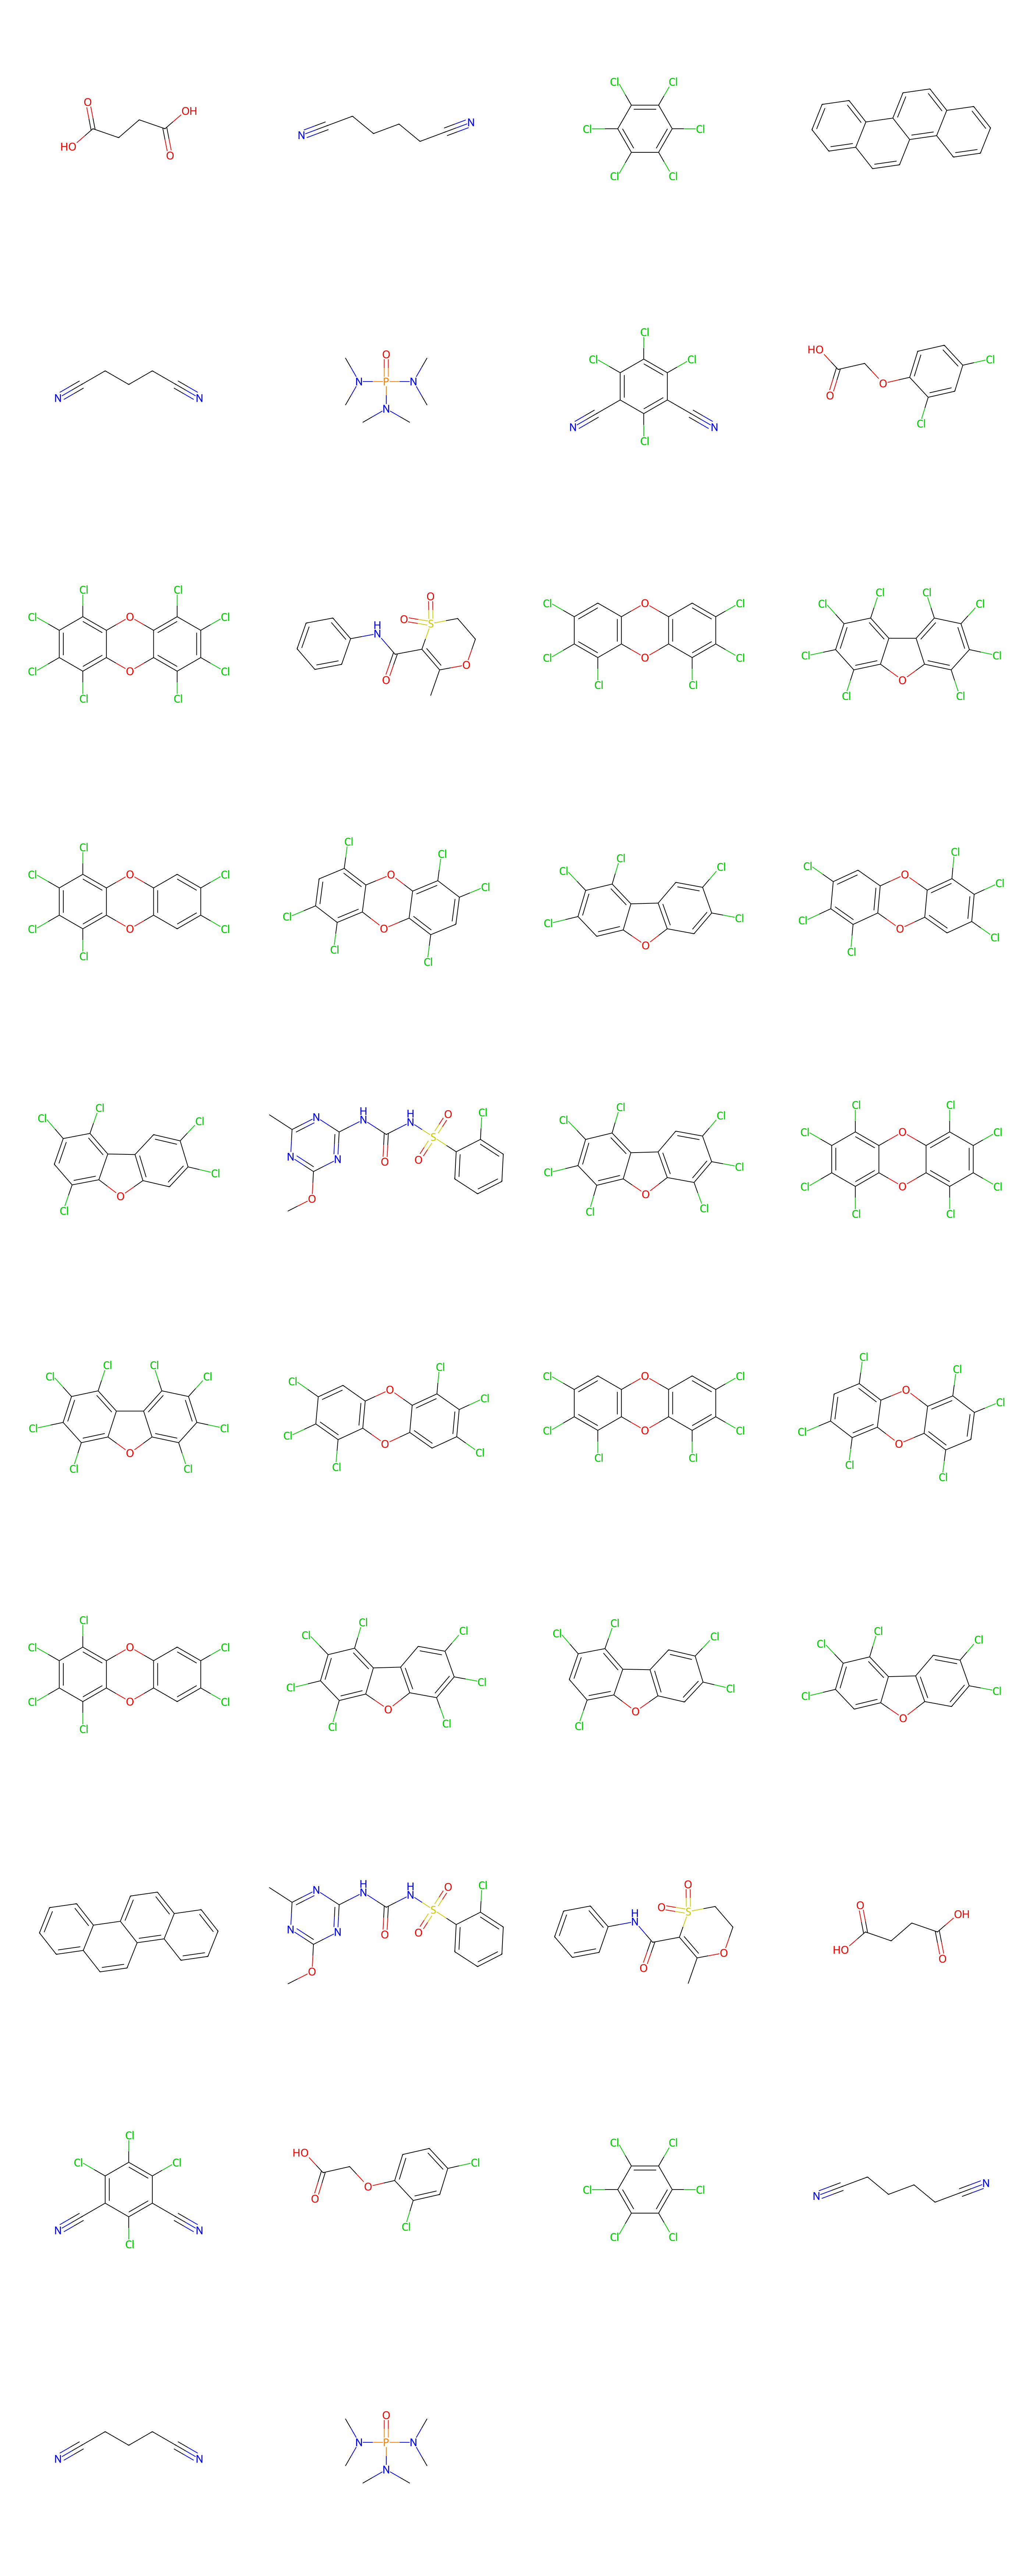

In [91]:
df_combined_overlap = df_combined[df_combined['inchikey'].isin(df_to_check['inchikey'].head(19).values)]
smiles = df_combined_overlap['standardized_smiles'].tolist()
Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(smi) for smi in smiles], molsPerRow=4, subImgSize=(700, 700))

### seems like most come from same chemical series, perhaps same source?

In [93]:
#find matchers between mols and mols_opera, if same molecule, copy proprety from mols_opera to mols
mols = [Chem.MolFromSmiles(smi) for smi in list(set(smiles))]
print(len(mols))
#first, get inchikeys from mols_opera
inchikeys_opera = []
for mol in mols_opera:
     inchikeys_opera.append(Chem.MolToInchiKey(mol))
#second, get inchikeys from mols
inchikeys_mols = []
for mol in mols:
     inchikeys_mols.append(Chem.MolToInchiKey(mol))
#third, find matches
matches = []
for inchikey_opera in inchikeys_opera:
     for inchikey_mol in inchikeys_mols:
          if inchikey_opera == inchikey_mol:
               matches.append(inchikey_opera)
               break
#get the VP Reference from mols_opera, add this property to mols
for mol_opera in mols_opera:
     for mol in mols:
          if Chem.MolToInchiKey(mol_opera) == Chem.MolToInchiKey(mol):
               mol.SetProp('VP Reference', mol_opera.GetProp('VP Reference'))
               break
          

19


Counter({'RORDORF,BF (1989)': 9, 'DAUBERT,TE & DANNER,RP (1989)': 2, 'TOMLIN,C (2003)': 2, 'BOSCH,SJ (1983)': 1, 'TOMLIN,C (2003); <0.0056 mPa': 1, 'YAWS,CL (1994)': 1, 'YAWS,CL (1994A)': 1, 'HOYER,H & PEPERLE,W (1958)': 1, 'SCHOENE,K ET AL. (1984)': 1})


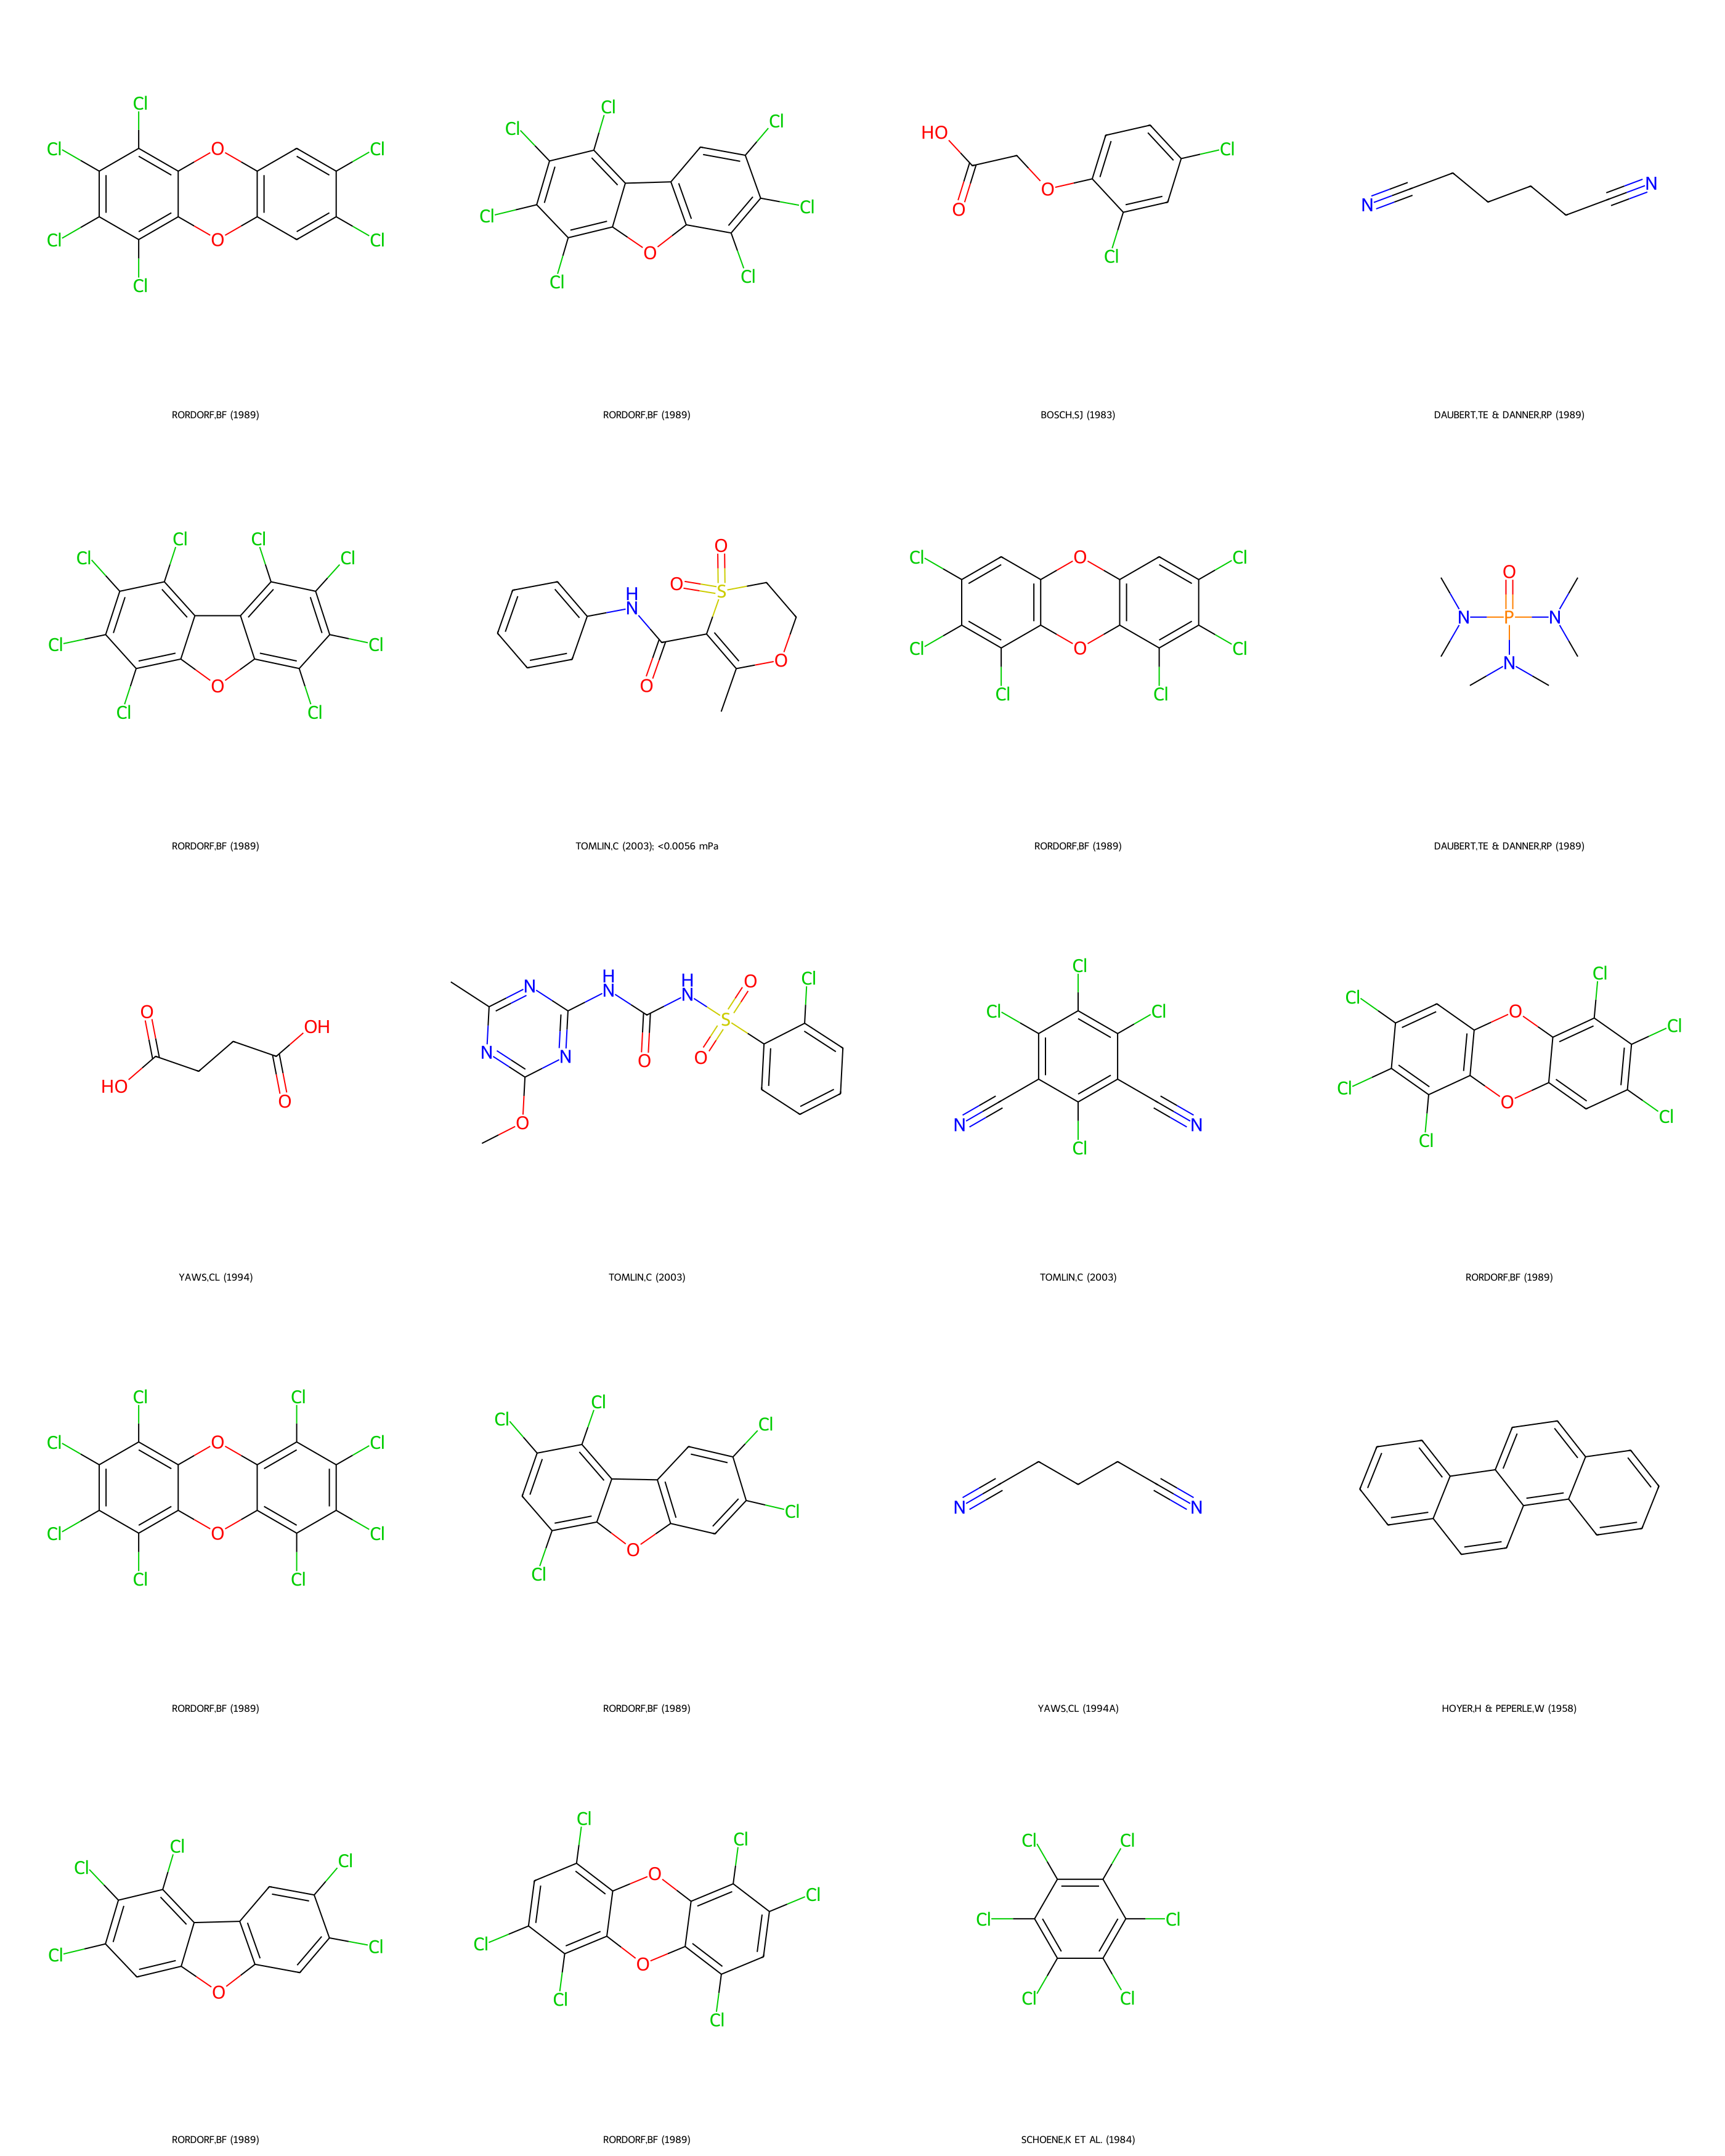

In [94]:
#count the values of VP Reference
from collections import Counter
print(Counter([mol.GetProp('VP Reference') for mol in mols]))
Draw.MolsToGridImage(mols = mols, molsPerRow=4, subImgSize=(700, 700), legends=[mol.GetProp('VP Reference') for mol in mols])



tried to find reference(s) for the values reported in the Naef and Acree paper, without success. Therefore, the values are taken from Rordorf for these values

In [95]:
df_further_curation = df_combined.copy()
print(len(df_further_curation))
for m in mols:
    if m.GetProp('VP Reference') == 'RORDORF,BF (1989)':
        print('Dropping...')
        inchikey = Chem.MolToInchiKey(m)
        df_further_curation = df_further_curation[~((df_further_curation['inchikey']==inchikey) & (df_further_curation['source']=='Naef_Acree'))]
print(len(df_further_curation))

4436
Dropping...
Dropping...
Dropping...
Dropping...
Dropping...
Dropping...
Dropping...
Dropping...
Dropping...
4427


In [96]:
mols_to_curate = [m for m in mols if m.GetProp('VP Reference') != 'RORDORF,BF (1989)']
df_to_check = df_to_check[df_to_check['inchikey'].isin([Chem.MolToInchiKey(m) for m in mols_to_curate])]
df_to_check

OPERA  Naef_Acree                     inchikey  abs_diff
810 -8.522898      -3.213  VJYIFXVZLXQVHO-UHFFFAOYSA-N  5.309898
559 -6.875098      -1.959  OVSKIKFHRZPJSS-UHFFFAOYSA-N  4.916098
71  -1.043198       2.095  BTGRAWJCKBQKAO-UHFFFAOYSA-N  3.138198
215  0.787702       3.706  GNOIPBMMFNIUFM-UHFFFAOYSA-N  2.918298
15  -5.251899      -2.876  AMEKQAFGQBKLKX-UHFFFAOYSA-N  2.375899
838 -6.080598      -3.750  WDECIBYCCFPHNR-UHFFFAOYSA-N  2.330598
989  0.040802       2.230  ZTOMUSMDRMJOTH-UHFFFAOYSA-N  2.189198
96  -2.619799      -0.519  CKAPSXZOOQJIBF-UHFFFAOYSA-N  2.100799
384 -4.594099      -2.510  KDYFGRWQOYBRFD-UHFFFAOYSA-N  2.084099
104 -4.119198      -2.092  CRQQGFGUEAVUIL-UHFFFAOYSA-N  2.027198

In [97]:
print(df_combined[df_combined['inchikey']=='VJYIFXVZLXQVHO-UHFFFAOYSA-N']['standardized_smiles'].values[0])
# m = [mol for mol in mols_to_curate if Chem.MolToInchiKey(mol) == 'VJYIFXVZLXQVHO-UHFFFAOYSA-N'][0]
# print(m.GetProp('VP Reference'))
print('Literature val: ', np.log10(3*10**-9)) #https://doi.org/10.1002/(SICI)1526-4998(200006)56:6<521::AID-PS155>3.0.CO;2-Y
df_combined[df_combined['inchikey']=='VJYIFXVZLXQVHO-UHFFFAOYSA-N']


COc1nc(C)nc(NC(=O)NS(=O)(=O)c2ccccc2Cl)n1
Literature val:  -8.522878745280337


standardized_smiles  log10_VP_Pa  \
2198  COc1nc(C)nc(NC(=O)NS(=O)(=O)c2ccccc2Cl)n1    -8.522898   
2628  COc1nc(C)nc(NC(=O)NS(=O)(=O)c2ccccc2Cl)n1    -3.213000   

                         inchikey      source  
2198  VJYIFXVZLXQVHO-UHFFFAOYSA-N       OPERA  
2628  VJYIFXVZLXQVHO-UHFFFAOYSA-N  Naef_Acree

In [98]:
#drop this datapoint
df_further_curation = df_further_curation[~((df_further_curation['inchikey']=='VJYIFXVZLXQVHO-UHFFFAOYSA-N') & (df_further_curation['source']=='Naef_Acree'))]

In [99]:
print(df_combined[df_combined['inchikey']=='OVSKIKFHRZPJSS-UHFFFAOYSA-N']['standardized_smiles'].values[0])
# m = [mol for mol in mols_to_curate if Chem.MolToInchiKey(mol) == 'VJYIFXVZLXQVHO-UHFFFAOYSA-N'][0]
# print(m.GetProp('VP Reference'))
print('Literature val: ', np.log10(1.40*10**-7 * 133.322),np.log10(1.9*10**-5)) #from http://npic.orst.edu/factsheets/archive/2,4-DTech.html#references
df_combined[df_combined['inchikey']=='OVSKIKFHRZPJSS-UHFFFAOYSA-N']


O=C(O)COc1ccc(Cl)cc1Cl
Literature val:  -4.728970144313402 -4.721246399047171


standardized_smiles  log10_VP_Pa                     inchikey  \
1741  O=C(O)COc1ccc(Cl)cc1Cl    -6.875098  OVSKIKFHRZPJSS-UHFFFAOYSA-N   
2809  O=C(O)COc1ccc(Cl)cc1Cl    -1.959000  OVSKIKFHRZPJSS-UHFFFAOYSA-N   

          source  
1741       OPERA  
2809  Naef_Acree

In [100]:
#both values in contrast with other literature values, drop both
df_further_curation = df_further_curation[~(df_further_curation['inchikey']=='OVSKIKFHRZPJSS-UHFFFAOYSA-N')]


In [101]:
print(df_combined[df_combined['inchikey']=='BTGRAWJCKBQKAO-UHFFFAOYSA-N']['standardized_smiles'].values[0])
# m = [mol for mol in mols_to_curate if Chem.MolToInchiKey(mol) == 'BTGRAWJCKBQKAO-UHFFFAOYSA-N'][0]
# print(m.GetProp('VP Reference'))
print('Literature val: ', np.log10((0.37530252785))) 
df_combined[df_combined['inchikey']=='BTGRAWJCKBQKAO-UHFFFAOYSA-N']


N#CCCCCC#N
Literature val:  -0.42561851038678744


standardized_smiles  log10_VP_Pa                     inchikey      source
743           N#CCCCCC#N    -1.043198  BTGRAWJCKBQKAO-UHFFFAOYSA-N       OPERA
3476          N#CCCCCC#N     2.095000  BTGRAWJCKBQKAO-UHFFFAOYSA-N  Naef_Acree

In [102]:
#drop both
df_further_curation = df_further_curation[~(df_further_curation['inchikey']=='BTGRAWJCKBQKAO-UHFFFAOYSA-N')]

In [103]:
print(df_combined[df_combined['inchikey']=='GNOIPBMMFNIUFM-UHFFFAOYSA-N']['standardized_smiles'].values[0])
# m = [mol for mol in mols_to_curate if Chem.MolToInchiKey(mol) == 'GNOIPBMMFNIUFM-UHFFFAOYSA-N'][0]
# print(m.GetProp('VP Reference'))
print('Literature val: ', np.log10((0.07*133.322)), np.log10((0.03*133.322)))
df_combined[df_combined['inchikey']=='GNOIPBMMFNIUFM-UHFFFAOYSA-N']



CN(C)P(=O)(N(C)C)N(C)C
Literature val:  0.9699998600226174 0.6020230747280229


standardized_smiles  log10_VP_Pa                     inchikey  \
1534  CN(C)P(=O)(N(C)C)N(C)C     0.787702  GNOIPBMMFNIUFM-UHFFFAOYSA-N   
3977  CN(C)P(=O)(N(C)C)N(C)C     3.706000  GNOIPBMMFNIUFM-UHFFFAOYSA-N   

          source  
1534       OPERA  
3977  Naef_Acree

In [104]:
#drop naef_acree
df_further_curation = df_further_curation[~((df_further_curation['inchikey']=='GNOIPBMMFNIUFM-UHFFFAOYSA-N') & (df_further_curation['source']=='Naef_Acree'))]

In [105]:
print(df_combined[df_combined['inchikey']=='AMEKQAFGQBKLKX-UHFFFAOYSA-N']['standardized_smiles'].values[0])
# m = [mol for mol in mols_to_curate if Chem.MolToInchiKey(mol) == 'AMEKQAFGQBKLKX-UHFFFAOYSA-N'][0]
# print(m.GetProp('VP Reference'))
print(np.log10(1.39*10**-2),np.log10(5.6*10**3)) 
df_combined[df_combined['inchikey']=='AMEKQAFGQBKLKX-UHFFFAOYSA-N']



CC1=C(C(=O)Nc2ccccc2)S(=O)(=O)CCO1
-1.856985199745905 3.7481880270062002


standardized_smiles  log10_VP_Pa  \
1923  CC1=C(C(=O)Nc2ccccc2)S(=O)(=O)CCO1    -5.251899   
2678  CC1=C(C(=O)Nc2ccccc2)S(=O)(=O)CCO1    -2.876000   

                         inchikey      source  
1923  AMEKQAFGQBKLKX-UHFFFAOYSA-N       OPERA  
2678  AMEKQAFGQBKLKX-UHFFFAOYSA-N  Naef_Acree

In [106]:
#no conclusive literature value, drop this inchikey
df_further_curation = df_further_curation[~(df_further_curation['inchikey']=='AMEKQAFGQBKLKX-UHFFFAOYSA-N')]

In [107]:
print(df_combined[df_combined['inchikey']=='WDECIBYCCFPHNR-UHFFFAOYSA-N']['standardized_smiles'].values[0])
# m = [mol for mol in mols_to_curate if Chem.MolToInchiKey(mol) == 'WDECIBYCCFPHNR-UHFFFAOYSA-N'][0]
# print(m.GetProp('VP Reference'))
p_log_torr_298 = 13.07-6340/(298.15+75)
p_torr_298 = 10**p_log_torr_298
p_pa_298 = p_torr_298*133.322
p_log10_pa_298 = np.log10(p_pa_298)
print(p_log10_pa_298)
df_combined[df_combined['inchikey']=='WDECIBYCCFPHNR-UHFFFAOYSA-N']


c1ccc2c(c1)ccc1c3ccccc3ccc21
-1.7955845795628569


standardized_smiles  log10_VP_Pa                     inchikey  \
1007  c1ccc2c(c1)ccc1c3ccccc3ccc21    -6.080598  WDECIBYCCFPHNR-UHFFFAOYSA-N   
2552  c1ccc2c(c1)ccc1c3ccccc3ccc21    -3.750000  WDECIBYCCFPHNR-UHFFFAOYSA-N   

          source  
1007       OPERA  
2552  Naef_Acree

In [108]:
df_further_curation = df_further_curation[~(df_further_curation['inchikey']=='WDECIBYCCFPHNR-UHFFFAOYSA-N')]

In [109]:
print(df_combined[df_combined['inchikey']=='ZTOMUSMDRMJOTH-UHFFFAOYSA-N']['standardized_smiles'].values[0])
# m = [mol for mol in mols_to_curate if Chem.MolToInchiKey(mol) == 'ZTOMUSMDRMJOTH-UHFFFAOYSA-N'][0]
# print(m.GetProp('VP Reference'))
print('Literature val: ', np.log10(1.1452393301000001)) 
df_combined[df_combined['inchikey']=='ZTOMUSMDRMJOTH-UHFFFAOYSA-N']


N#CCCCC#N
Literature val:  0.058896254257089865


standardized_smiles  log10_VP_Pa                     inchikey      source
1233           N#CCCCC#N     0.040802  ZTOMUSMDRMJOTH-UHFFFAOYSA-N       OPERA
3517           N#CCCCC#N     2.230000  ZTOMUSMDRMJOTH-UHFFFAOYSA-N  Naef_Acree

In [110]:
#value for OPERA in according with a different publication
df_further_curation = df_further_curation[~((df_further_curation['inchikey']=='ZTOMUSMDRMJOTH-UHFFFAOYSA-N') & (df_further_curation['source']=='Naef_Acree'))]

In [111]:
print(df_combined[df_combined['inchikey']=='CKAPSXZOOQJIBF-UHFFFAOYSA-N']['standardized_smiles'].values[0])
# m = [mol for mol in mols_to_curate if Chem.MolToInchiKey(mol) == 'CKAPSXZOOQJIBF-UHFFFAOYSA-N'][0]
# print(m.GetProp('VP Reference'))
print('Literature val: ', np.log10(21.8*10**-3)) #https://www.sciencedirect.com/science/article/pii/S0045653504008264?via%3Dihub
log_p_torr = -2.924
p_torr = 10**log_p_torr
p_pa = p_torr*133.322
p_log10_pa = np.log10(p_pa)
print('Literature val: ', p_log10_pa) #https://pubs.acs.org/doi/abs/10.1021/ac00277a051
log_p_torr = -3.040
p_torr = 10**log_p_torr
p_pa = p_torr*133.322
p_log10_pa = np.log10(p_pa)
print('Literature val: ', p_log10_pa) #https://pubs.acs.org/doi/abs/10.1021/ac00277a051
log_p_torr = -2.643
p_torr = 10**log_p_torr
p_pa = p_torr*133.322
p_log10_pa = np.log10(p_pa)
print('Literature val: ', p_log10_pa) #https://pubs.acs.org/doi/abs/10.1021/ac00277a051
print('Literature vals: ',-0.799,-0.923,-0.518,-0.896) #https://pubs.acs.org/doi/abs/10.1021/je00061a003
print('Literature val: ',np.log10(3.11*10**-3)) #https://www.sciencedirect.com/science/article/pii/0045653594904456?via%3Dihub
df_combined[df_combined['inchikey']=='CKAPSXZOOQJIBF-UHFFFAOYSA-N']


Clc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl
Literature val:  -1.6615435063953952
Literature val:  -0.7990981799916395
Literature val:  -0.9150981799916396
Literature val:  -0.5180981799916393
Literature vals:  -0.799 -0.923 -0.518 -0.896
Literature val:  -2.5072396109731625


standardized_smiles  log10_VP_Pa                     inchikey  \
829   Clc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl    -2.619799  CKAPSXZOOQJIBF-UHFFFAOYSA-N   
2977  Clc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl    -0.519000  CKAPSXZOOQJIBF-UHFFFAOYSA-N   

          source  
829        OPERA  
2977  Naef_Acree

In [112]:
#too many contradicitng values, drop this inchikey
df_further_curation = df_further_curation[~(df_further_curation['inchikey']=='CKAPSXZOOQJIBF-UHFFFAOYSA-N')]

In [113]:
print(df_combined[df_combined['inchikey']=='KDYFGRWQOYBRFD-UHFFFAOYSA-N']['standardized_smiles'].values[0])
# m = [mol for mol in mols_to_curate if Chem.MolToInchiKey(mol) == 'KDYFGRWQOYBRFD-UHFFFAOYSA-N'][0]
# print(m.GetProp('VP Reference'))
print('Literature val: ', np.log10(6.4*10**-5),np.log10(4.46*10**-5))
df_combined[df_combined['inchikey']=='KDYFGRWQOYBRFD-UHFFFAOYSA-N']


O=C(O)CCC(=O)O
Literature val:  -4.1938200260161125 -4.350665141287858


standardized_smiles  log10_VP_Pa                     inchikey      source
684       O=C(O)CCC(=O)O    -4.594099  KDYFGRWQOYBRFD-UHFFFAOYSA-N       OPERA
2737      O=C(O)CCC(=O)O    -2.510000  KDYFGRWQOYBRFD-UHFFFAOYSA-N  Naef_Acree

In [114]:
#opera value is in line with other sources, naef_acree value is not, drop naef_acree value
df_further_curation = df_further_curation[~((df_further_curation['inchikey']=='KDYFGRWQOYBRFD-UHFFFAOYSA-N') & (df_further_curation['source']=='Naef_Acree'))]


In [115]:
print(df_combined[df_combined['inchikey']=='CRQQGFGUEAVUIL-UHFFFAOYSA-N']['standardized_smiles'].values[0])
# m = [mol for mol in mols_to_curate if Chem.MolToInchiKey(mol) == 'CRQQGFGUEAVUIL-UHFFFAOYSA-N'][0]
# print(m.GetProp('VP Reference'))
print('Literature vals: ', np.log10(7.6*10**-5), np.log10(81*10**-6))
df_combined[df_combined['inchikey']=='CRQQGFGUEAVUIL-UHFFFAOYSA-N']


N#Cc1c(Cl)c(Cl)c(Cl)c(C#N)c1Cl
Literature vals:  -4.119186407719209 -4.0915149811213505


standardized_smiles  log10_VP_Pa  \
1728  N#Cc1c(Cl)c(Cl)c(Cl)c(C#N)c1Cl    -4.119198   
2796  N#Cc1c(Cl)c(Cl)c(Cl)c(C#N)c1Cl    -2.092000   

                         inchikey      source  
1728  CRQQGFGUEAVUIL-UHFFFAOYSA-N       OPERA  
2796  CRQQGFGUEAVUIL-UHFFFAOYSA-N  Naef_Acree

In [116]:
#opera value is in line with other sources, naef_acree value is not, drop naef_acree value
df_further_curation = df_further_curation[~((df_further_curation['inchikey']=='CRQQGFGUEAVUIL-UHFFFAOYSA-N') & (df_further_curation['source']=='Naef_Acree'))]


In [117]:
df_further_curation

standardized_smiles  log10_VP_Pa  \
0                              CC(O)C(=O)O     1.035002   
1                 O=C(O)c1c(Cl)ccc(Cl)c1Cl    -1.134698   
2         c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34    -6.135498   
3     COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C    -4.594099   
4                     O=C(O)c1cccc(Cl)c1Cl    -1.517198   
...                                    ...          ...   
4434                                    CF     6.582000   
4435                                   C#C     6.591000   
4436                                FC(F)F     6.672000   
4437                                     C     7.790000   
4438                             FC(F)(F)F     7.910000   

                         inchikey      source  
0     JVTAAEKCZFNVCJ-UHFFFAOYSA-N       OPERA  
1     XZIDTOHMJBOSOX-UHFFFAOYSA-N       OPERA  
2     FMMWHPNWAFZXNH-UHFFFAOYSA-N       OPERA  
3     ZPUCINDJVBIVPJ-UHFFFAOYSA-N       OPERA  
4     QAOJBHRZQQDFHA-UHFFFAOYSA-N       OPERA  
...                           ...         ...  
4434  NBVXSUQYWXRMNV-UHFFFAOYSA-N  Naef_Acree  
4435  HSFWRNGVRCDJHI-UHFFFAOYSA-N  Naef_Acree  
4436  XPDWGBQVDMORPB-UHFFFAOYSA-N  Naef_Acree  
4437  VNWKTOKETHGBQD-UHFFFAOYSA-N  Naef_Acree  
4438  TXEYQDLBPFQVAA-UHFFFAOYSA-N  Naef_Acree  

[4412 rows x 4 columns]

In [118]:
import matplotlib.pyplot as plt

def plot_duplicate_correlation_single(df, combination):
    df1 = df[df['source'] == combination[0]]
    df2 = df[df['source'] == combination[1]]

    # Get overlapping inchikeys
    inchikeys_source1 = df1['inchikey'].unique()
    inchikeys_source2 = df2['inchikey'].unique()
    inchikeys_overlap = list(set(inchikeys_source1).intersection(inchikeys_source2))

    # Get duplicates
    df1_duplicates = df1[df1['inchikey'].isin(inchikeys_overlap)]
    df2_duplicates = df2[df2['inchikey'].isin(inchikeys_overlap)]

    # Drop duplicates
    df1_duplicates = df1_duplicates.drop_duplicates(subset=['inchikey'])
    df2_duplicates = df2_duplicates.drop_duplicates(subset=['inchikey'])

    # Sort by inchikey
    df_subset_duplicates_source1 = df1_duplicates.sort_values(by=['inchikey'])
    df_subset_duplicates_source2 = df2_duplicates.sort_values(by=['inchikey'])

    # Get minimum and maximum for the plots
    minimum = min(df_subset_duplicates_source1['log10_VP_Pa'].min(), df_subset_duplicates_source2['log10_VP_Pa'].min())
    maximum = max(df_subset_duplicates_source1['log10_VP_Pa'].max(), df_subset_duplicates_source2['log10_VP_Pa'].max())

    # Create a single plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Scatter plot
    ax.scatter(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'], s=5)
    ax.set_xlabel(combination[0])
    ax.set_ylabel(combination[1])

    # Make square
    ax.set_aspect('equal', 'box')

    # Add diagonal line
    ax.plot([-20, 10], [-20, 10], color='black')

    # Add dashed lines at 1 log unit difference
    ax.plot([-20, 10], [-21, 9], color='black', linestyle='dashed')
    ax.plot([-21, 9], [-20, 10], color='black', linestyle='dashed')

    # Add dashed lines at 2 log unit difference
    ax.plot([-20, 10], [-22, 8], color='black', linestyle='dotted')
    ax.plot([-22, 8], [-20, 10], color='black', linestyle='dotted')

    # Add metrics: MAE, RMSE, R2, Pearson, Spearman, Kendall
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import numpy as np
    from scipy.stats import pearsonr, spearmanr, kendalltau

    # Remove nan values
    df_subset_duplicates_source1 = df_subset_duplicates_source1.dropna()
    df_subset_duplicates_source2 = df_subset_duplicates_source2.dropna()

    # Calculate metrics
    mae = mean_absolute_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    rmse = np.sqrt(mean_squared_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa']))
    r2 = r2_score(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    pearson = pearsonr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    spearman = spearmanr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    kendall = kendalltau(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])

    # Also get: fraction exactly the same (diff smaller than 0.01), fraction within 0.3 log unit,
    # fraction within 1 log units and number of points with diff larger than 2 log units
    vals_1 = df_subset_duplicates_source1['log10_VP_Pa'].values
    vals_2 = df_subset_duplicates_source2['log10_VP_Pa'].values
    diff = vals_1 - vals_2
    diff_abs = np.abs(diff)

    fraction_exactly_same = len(diff_abs[diff_abs < 0.01]) / len(diff_abs)
    fraction_within_03 = len(diff_abs[diff_abs < 0.3]) / len(diff_abs)
    fraction_within_1 = len(diff_abs[diff_abs < 1]) / len(diff_abs)
    number_larger_2 = len(diff_abs[diff_abs > 2])

    # Add metrics and number of points to plot
    text_box = ax.text(0.05, 0.95, 'MAE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nN: {} points\nPearson: {:.3f}\nSpearman: {:.3f}\nKendall: {:.3f}'.format(mae, rmse, r2, len(df_subset_duplicates_source1), pearson[0], spearman[0], kendall[0]), transform=ax.transAxes, verticalalignment='top')
    text_box.set_bbox(dict(facecolor='white', edgecolor='black'))

    # Similar box in bottom right with fraction exactly the same, fraction within 0.3 log unit,
    # fraction within 1 log units and number of points with diff larger than 2 log units
    text_box = ax.text(0.50, 0.05, 'Fraction exactly same: {:.2f}\nFraction within 0.3: {:.2f}\nFraction within 1: {:.2f}\nNumber larger 2: {}'.format(fraction_exactly_same, fraction_within_03, fraction_within_1, number_larger_2), transform=ax.transAxes, verticalalignment='bottom')
    text_box.set_bbox(dict(facecolor='white', edgecolor='black'))

    ax.grid()

    # Set limit
    ax.set_xlim(minimum - 2, maximum + 2)
    ax.set_ylim(minimum - 2, maximum + 2)

    plt.tight_layout()
    plt.show()


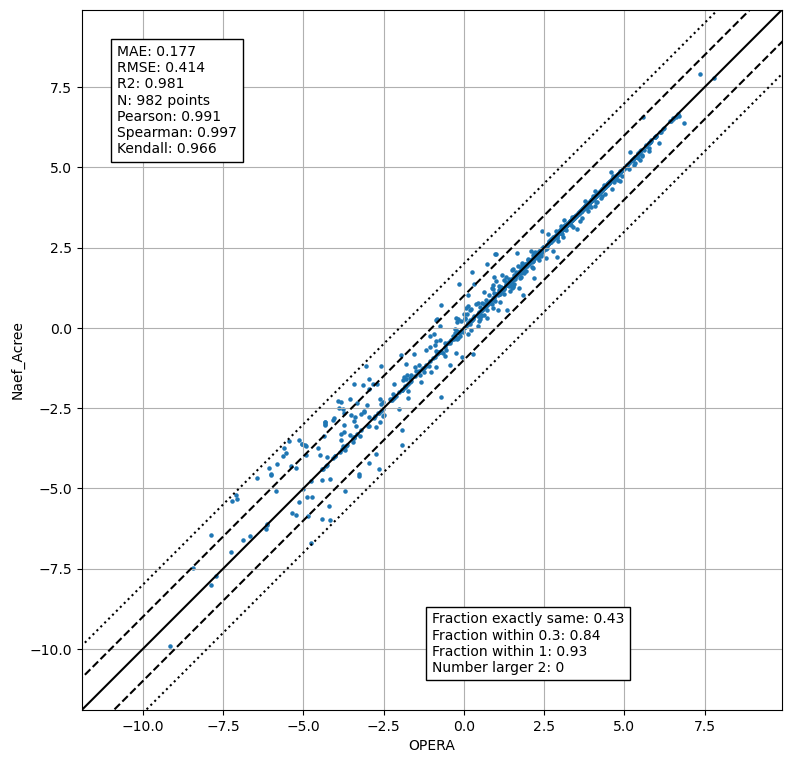

In [119]:
#plot duplicates again
plot_duplicate_correlation_single(df_further_curation,['OPERA','Naef_Acree'])

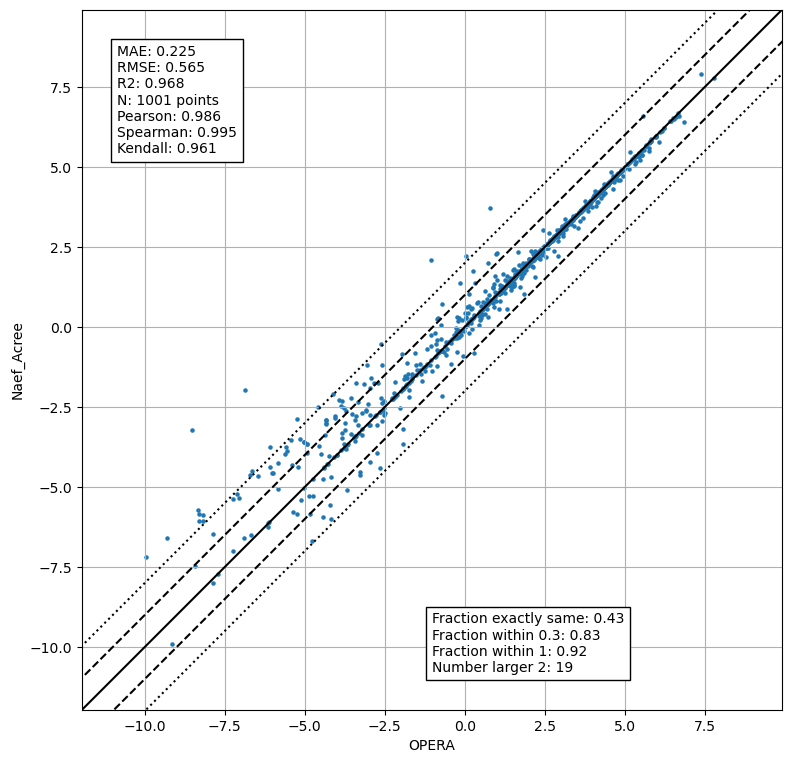

In [128]:
#Also sho same plot pre-curation
plot_duplicate_correlation_single(df_combined,['OPERA','Naef_Acree'])

In [120]:
mols_post_cur = [Chem.MolFromSmiles(smi) for smi in df_further_curation['standardized_smiles']]
descriptors_post_cur = [getMolDescriptors(m) for m in mols_post_cur]
descriptor_df_post_cur = pd.DataFrame(descriptors_post_cur)
df_combined_descritptors_post_cur = df_further_curation.merge(descriptor_df_post_cur, on='inchikey')
df_combined_descritptors_post_cur = df_combined_descritptors_post_cur.drop_duplicates()
outputs_combined_post_cur = train_grouped_kfold(df_combined_descritptors_post_cur,params,RDKit_feature_names,name='outputs_combined_no_duplicates_post_cur',split_on = 'inchikey',y='log10_VP_Pa',n_splits=5,n_repeats=3,random_state=2652124,normalize_x=False)

[15:39:03] unrecognized chirality tag (8) on atom 6 is ignored.
[15:39:03] unrecognized chirality tag (8) on atom 17 is ignored.
[15:39:04] unrecognized chirality tag (8) on atom 4 is ignored.
[15:39:04] unrecognized chirality tag (8) on atom 11 is ignored.
[15:39:04] unrecognized chirality tag (8) on atom 1 is ignored.
[15:39:04] unrecognized chirality tag (8) on atom 7 is ignored.
[15:39:04] unrecognized chirality tag (8) on atom 13 is ignored.
[15:39:04] unrecognized chirality tag (8) on atom 3 is ignored.
[15:39:04] unrecognized chirality tag (8) on atom 11 is ignored.
[15:39:05] unrecognized chirality tag (8) on atom 9 is ignored.
[15:39:05] unrecognized chirality tag (8) on atom 6 is ignored.
[15:39:05] unrecognized chirality tag (8) on atom 5 is ignored.
[15:39:05] unrecognized chirality tag (8) on atom 6 is ignored.


Fold 1: RMSE = 0.586658586493831
Fold 2: RMSE = 0.5553573084928091
Fold 3: RMSE = 0.6685607074630266
Fold 4: RMSE = 0.6358362940843493
Fold 5: RMSE = 0.5749157083098152
Fold 6: RMSE = 0.540692700504669
Fold 7: RMSE = 0.6092077208031033
Fold 8: RMSE = 0.5856494164476059
Fold 9: RMSE = 0.5590054102765795
Fold 10: RMSE = 0.6035686212954509
Fold 11: RMSE = 0.6086687226585813
Fold 12: RMSE = 0.6133390565367713
Fold 13: RMSE = 0.5843415694956224
Fold 14: RMSE = 0.6368585306376014
Fold 15: RMSE = 0.5201410545126187


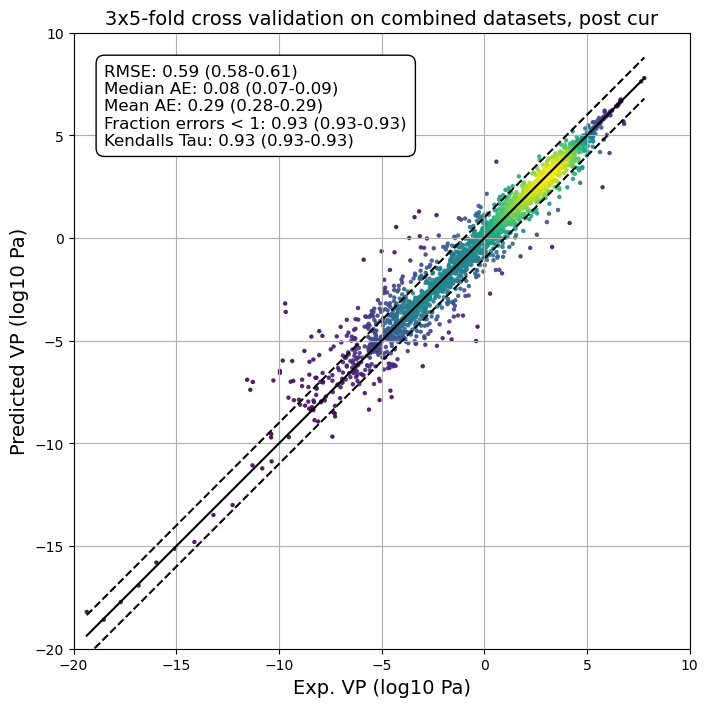

In [121]:
density_plot_single_custom_local(reals = outputs_combined_post_cur[0], predictions = outputs_combined_post_cur[1], bounds=[-20,10], molregnos=outputs_combined_post_cur[2], title='3x5-fold cross validation on combined datasets, post cur')

In [122]:
print(len(df_combined_descritptors_post_cur),len(df_further_curation))

4405 4412


In [123]:
df_combined_descritptors_post_cur['source'].value_counts()

source
OPERA         2353
Naef_Acree    2052
Name: count, dtype: int64

In [124]:
#save
df_combined_descritptors_post_cur.to_csv('OPERA_plus_Naef_Acree_incl_overlap_descriptors.csv')

In [125]:
df_combined_descritptors_post_cur
#drop duplicates, keep the one from OPERA. to this, first sort by source, then drop duplicates, then sort by inchikey
df_combined_descritptors_post_cur = df_combined_descritptors_post_cur.sort_values(by=['source'])
df_combined_descritptors_post_cur_OPERA = df_combined_descritptors_post_cur.drop_duplicates(subset=['inchikey'],keep='last')
df_combined_descritptors_post_cur_OPERA['source'].value_counts()

source
OPERA         2353
Naef_Acree    1069
Name: count, dtype: int64

Fold 1: RMSE = 0.8022163200255482
Fold 2: RMSE = 0.8076582226415595
Fold 3: RMSE = 0.7507232569648633
Fold 4: RMSE = 0.7821849397046761
Fold 5: RMSE = 0.8050888095214083
Fold 6: RMSE = 0.781538250195173
Fold 7: RMSE = 0.8330435138622658
Fold 8: RMSE = 0.7850735042360112
Fold 9: RMSE = 0.7419751412875807
Fold 10: RMSE = 0.8598698399861333
Fold 11: RMSE = 0.8271448038218197
Fold 12: RMSE = 0.8106715733934549
Fold 13: RMSE = 0.7052474888034631
Fold 14: RMSE = 0.7499435578662845
Fold 15: RMSE = 0.8120457626208641


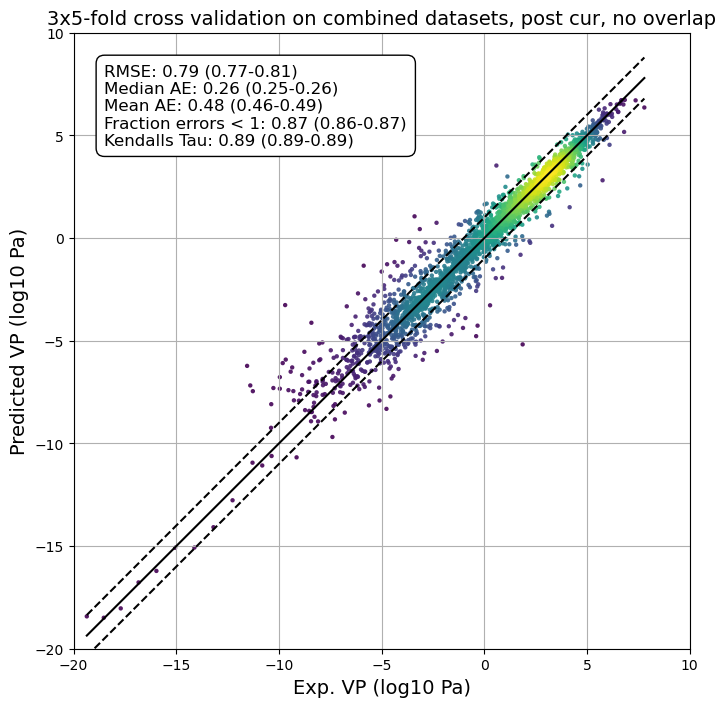

In [129]:
outputs_combined_post_cur_no_overlap_OPERA = train_grouped_kfold(df_combined_descritptors_post_cur_OPERA,params,RDKit_feature_names,name='outputs_combined_no_duplicates_post_cur_no_overlap',split_on = 'inchikey',y='log10_VP_Pa',n_splits=5,n_repeats=3,random_state=2652124,normalize_x=False)
density_plot_single_custom_local(reals = outputs_combined_post_cur_no_overlap_OPERA[0], predictions = outputs_combined_post_cur_no_overlap_OPERA[1], bounds=[-20,10], molregnos=outputs_combined_post_cur_no_overlap_OPERA[2], title='3x5-fold cross validation on combined datasets, post cur, no overlap')

In [130]:
df_combined_descritptors_post_cur
#drop duplicates, keep the one from OPERA. to this, first sort by source, then drop duplicates, then sort by inchikey
df_combined_descritptors_post_cur = df_combined_descritptors_post_cur.sort_values(by=['source'])
df_combined_descritptors_post_cur_Naef_Acree = df_combined_descritptors_post_cur.drop_duplicates(subset=['inchikey'],keep='first')
df_combined_descritptors_post_cur_Naef_Acree['source'].value_counts()

source
Naef_Acree    2051
OPERA         1371
Name: count, dtype: int64

In [131]:
outputs_combined_post_cur_no_overlap_Naef_Acree = train_grouped_kfold(df_combined_descritptors_post_cur_Naef_Acree,params,RDKit_feature_names,name='outputs_combined_no_duplicates_post_cur_no_overlap',split_on = 'inchikey',y='log10_VP_Pa',n_splits=5,n_repeats=3,random_state=2652124,normalize_x=False)
density_plot_single_custom_local(reals = outputs_combined_post_cur_no_overlap_Naef_Acree[0], predictions = outputs_combined_post_cur_no_overlap_Naef_Acree[1], bounds=[-20,10], molregnos=outputs_combined_post_cur_no_overlap_Naef_Acree[2], title='3x5-fold cross validation on combined datasets, post cur, no overlap')

Fold 1: RMSE = 0.732685518447984
Fold 2: RMSE = 0.8797902634307048
Fold 3: RMSE = 0.8171110384153271
Fold 4: RMSE = 0.698771943609674
Fold 5: RMSE = 0.7102855328480483
Fold 6: RMSE = 0.8312205443293195
Fold 7: RMSE = 0.7473851552634175
Fold 8: RMSE = 0.7969091230001782
Fold 9: RMSE = 0.72886367020688
Fold 10: RMSE = 0.7213732057924925
Fold 11: RMSE = 0.772071373889032
Fold 12: RMSE = 0.821857109178131
Fold 13: RMSE = 0.7887494603115744
Fold 14: RMSE = 0.7529623075565283
Fold 15: RMSE = 0.7385254132243054


Coefficients:  [[-0.46561233]]
Intercept:  [6.01115625]
R2:  0.659110851925996
MSE:  3.930619366457332


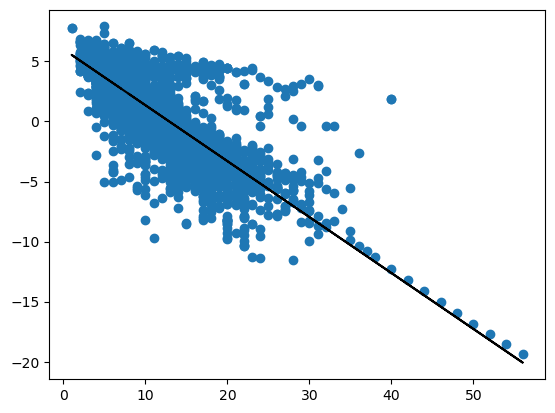

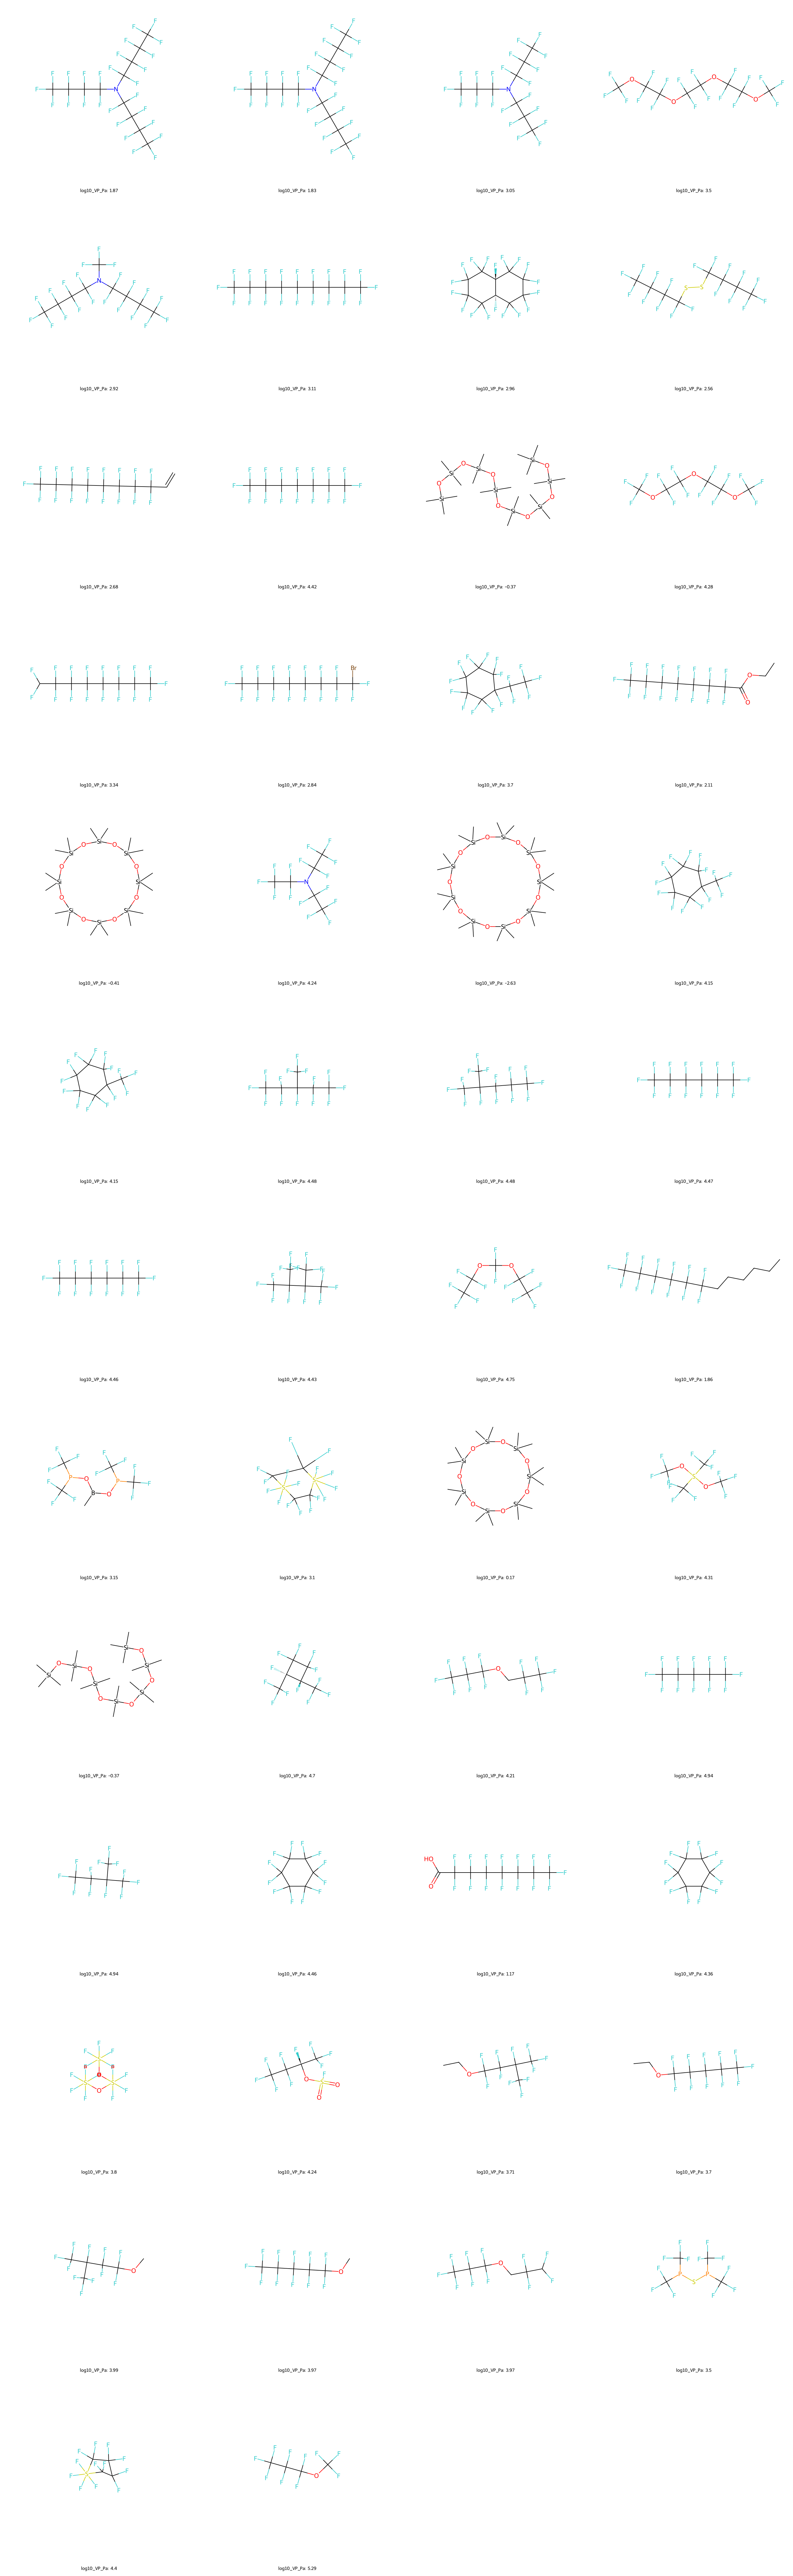

In [132]:
#plot HeavyAtomCount vs log10_VP_Pa
plt.scatter(df_combined_descritptors_post_cur['HeavyAtomCount'],df_combined_descritptors_post_cur['log10_VP_Pa'])
#fit linear regression, find biggest outliers
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

X = df_combined_descritptors_post_cur['HeavyAtomCount'].values.reshape(-1,1)
y = df_combined_descritptors_post_cur['log10_VP_Pa'].values.reshape(-1,1)
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
print('Coefficients: ', reg.coef_)
print('Intercept: ', reg.intercept_)
print('R2: ', r2_score(y, y_pred))
print('MSE: ', mean_squared_error(y, y_pred))
#plot regression line
plt.plot(X, y_pred, color='black')
plt.show()
#find top10 outliers, make df of these
df_outliers = df_combined_descritptors_post_cur.copy()
df_outliers['y_pred'] = y_pred
df_outliers['residual'] = df_outliers['log10_VP_Pa'] - df_outliers['y_pred']
df_outliers.sort_values(by=['residual'],ascending=False,inplace=True)
df_outliers
smiles = df_outliers['standardized_smiles'].head(50).tolist()
vps = df_outliers['log10_VP_Pa'].head(50).tolist()
#draw
Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(smi) for smi in smiles], molsPerRow=4, subImgSize=(700, 700), legends=[f'log10_VP_Pa: {round(vp,2)}' for vp in vps])

In [133]:
#now check how many of these mols we have already registered
df_further_curation

standardized_smiles  log10_VP_Pa  \
0                              CC(O)C(=O)O     1.035002   
1                 O=C(O)c1c(Cl)ccc(Cl)c1Cl    -1.134698   
2         c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34    -6.135498   
3     COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C    -4.594099   
4                     O=C(O)c1cccc(Cl)c1Cl    -1.517198   
...                                    ...          ...   
4434                                    CF     6.582000   
4435                                   C#C     6.591000   
4436                                FC(F)F     6.672000   
4437                                     C     7.790000   
4438                             FC(F)(F)F     7.910000   

                         inchikey      source  
0     JVTAAEKCZFNVCJ-UHFFFAOYSA-N       OPERA  
1     XZIDTOHMJBOSOX-UHFFFAOYSA-N       OPERA  
2     FMMWHPNWAFZXNH-UHFFFAOYSA-N       OPERA  
3     ZPUCINDJVBIVPJ-UHFFFAOYSA-N       OPERA  
4     QAOJBHRZQQDFHA-UHFFFAOYSA-N       OPERA  
...                           ...         ...  
4434  NBVXSUQYWXRMNV-UHFFFAOYSA-N  Naef_Acree  
4435  HSFWRNGVRCDJHI-UHFFFAOYSA-N  Naef_Acree  
4436  XPDWGBQVDMORPB-UHFFFAOYSA-N  Naef_Acree  
4437  VNWKTOKETHGBQD-UHFFFAOYSA-N  Naef_Acree  
4438  TXEYQDLBPFQVAA-UHFFFAOYSA-N  Naef_Acree  

[4412 rows x 4 columns]

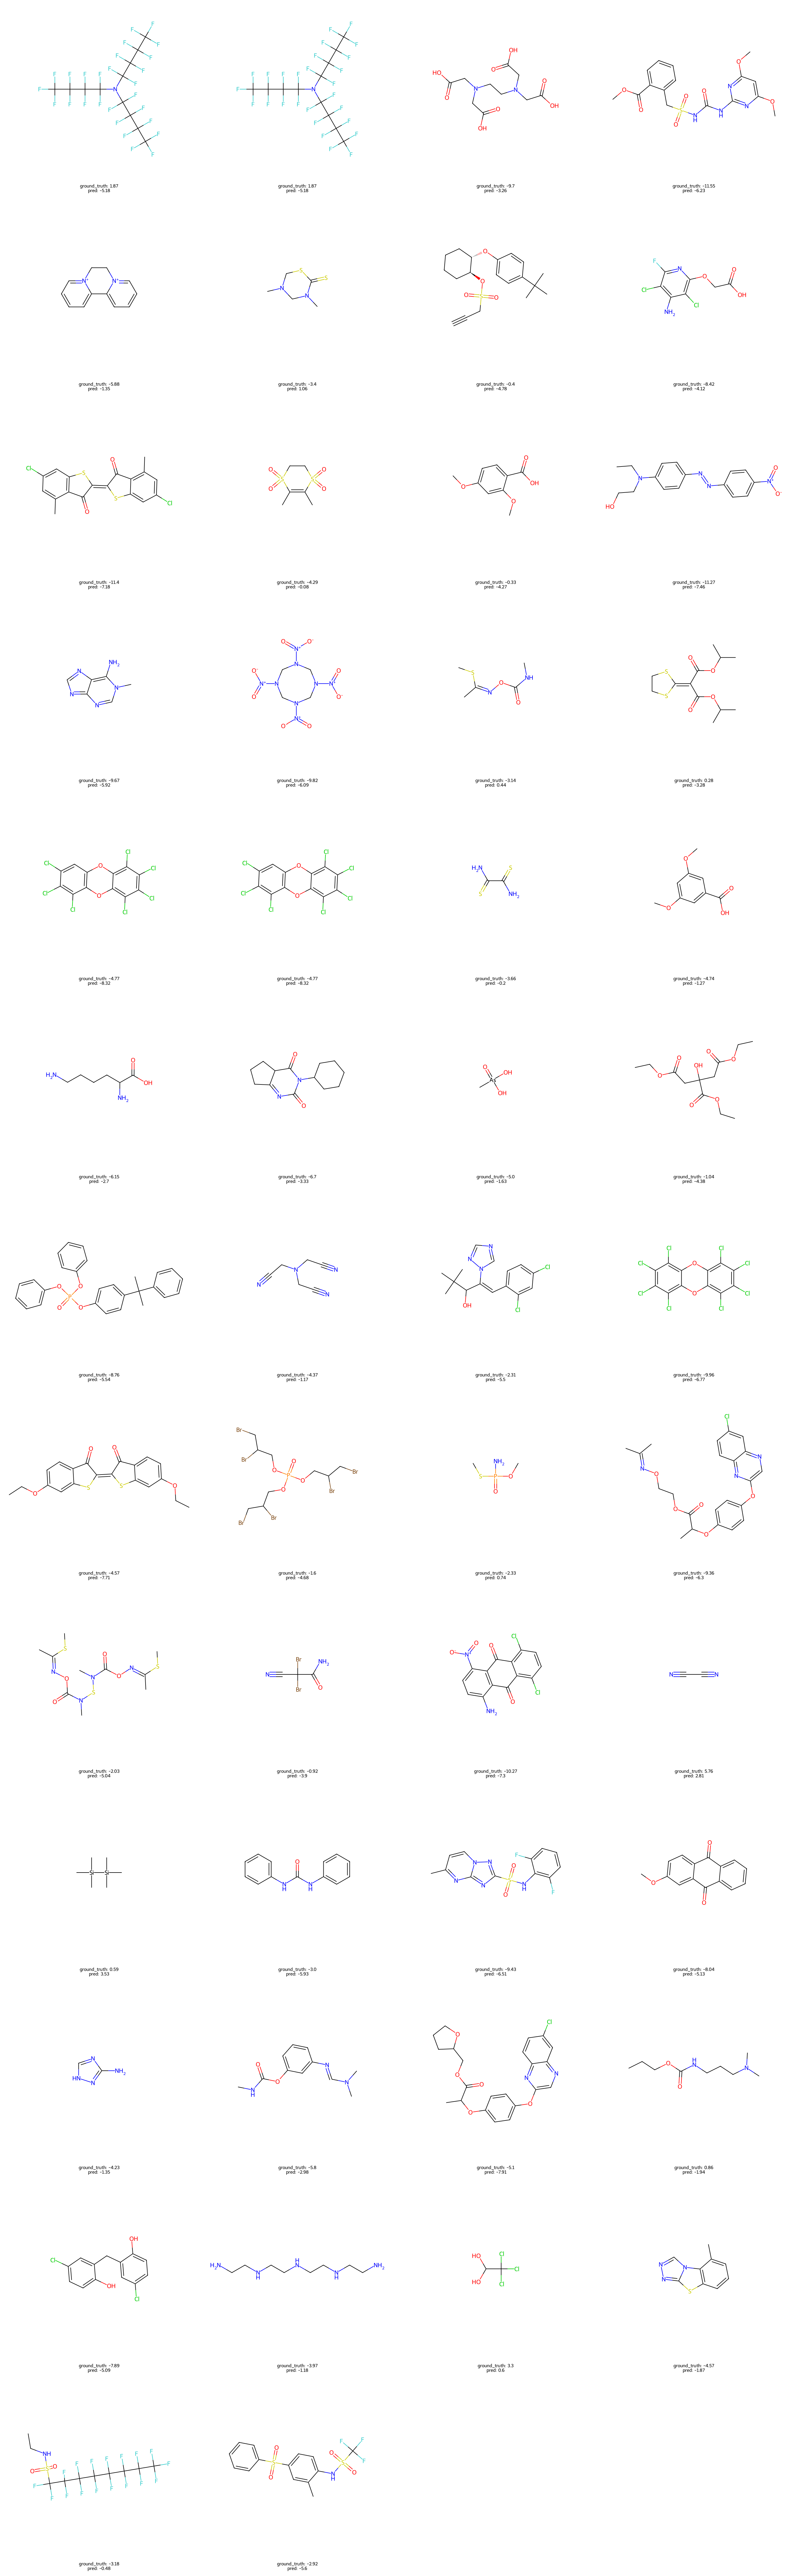

In [134]:
#make df from outputs_combined_post_cur_no_overlap, average over the 3x5 folds, and merge with df_combined_descritptors_post_cur on molregno
reals = outputs_combined_post_cur_no_overlap_OPERA[0]
preds = outputs_combined_post_cur_no_overlap_OPERA[1]
molregnos = outputs_combined_post_cur_no_overlap_OPERA[2]
reals_flat = [item for sublist in reals for item in sublist]
preds_flat = [item for sublist in preds for item in sublist]
molregnos_flat = [item for sublist in molregnos for item in sublist]
df_CV_new_set = pd.DataFrame({'reals': reals_flat, 'preds': preds_flat, 'inchikey': molregnos_flat})
df_CV_new_set = df_CV_new_set.groupby('inchikey').mean()
df_CV_new_set['abs_error'] = np.abs(df_CV_new_set['reals']-df_CV_new_set['preds'])
df_CV_new_set.sort_values(by=['abs_error'],ascending=False,inplace=True)

#merge with df_combined_descritptors_post_cur
df_CV_new_set = df_CV_new_set.merge(df_combined_descritptors_post_cur, on='inchikey')
df_CV_new_set.sort_values(by=['abs_error'],ascending=False,inplace=True)
#get the standardized smiles of the top 50 outliers, their prediction and the real value. Draw the mols with prediction and ground truth as legend
smiles = df_CV_new_set['standardized_smiles'].head(50).tolist()
reals = df_CV_new_set['reals'].head(50).tolist()
preds = df_CV_new_set['preds'].head(50).tolist()
Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(smi) for smi in smiles], molsPerRow=4, subImgSize=(700, 700), legends=[f'ground_truth: {round(ground_truth,2)}\npred: {round(pred,2)}' for ground_truth,pred in zip(reals,preds)])


In [144]:
df_old = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/Experiments_result_analysis/mdf_rdkit_dash_features_2980.csv')
df_old['inchikeys'] = df_old['molblock'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromMolBlock(x))) 
#get number of non=-overlapping inchikeys
inchikeys_old = df_old['inchikeys'].unique()
inchikeys_new = df_further_curation['inchikey'].unique()
non_overlapping_inchikeys = list(set(inchikeys_new).difference(inchikeys_old))
overlapping_inchikeys = list(set(inchikeys_new).intersection(inchikeys_old))
print(len(non_overlapping_inchikeys),len(df_further_curation),len(inchikeys_new),len(inchikeys_old),len(overlapping_inchikeys))

1541 4412 3429 2977 1888
